In [ ]:
!pip install numpy==1.26.4
!pip install pandas
!pip install sklearn
!pip install transformers datasets

# **CDS Project: Part 3**

*Institute of Software Security (E22)*  
*Hamburg University of Technology*  

## Learning objectives
---

- Choose an ML model architecture for vulnerability prediction
- Preprocess the dataset you created in project part 2 to fit the model you selected
- Split the dataset for cross validation
- Create the model training pipeline, train the model using the train set and optimize the model using the test set
- Create loss graphs of the learning behaviour
- Generate predictions for the validation set
- Evaluate the results using appropriate metrics (add questions: reduce overfitting? optional 5-fold cross validation)


## Materials
---

- Lecture Slides 2, 3, 5 and 6, 9.
- PyTorch Documentation: [Datasets and Data Loaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) 

## Project Description

In this project, you will create, train and evaluate your own machine learning model to predict vulnerabilities in source code. In addition, you will preprocess the data to prepare it to be used in the learning pipeline.
You will be using the dataset created in part 2 in this part. 

## **Task 1**

- There are several ML model architectures that you can use for vulnerabilitiy prediction such as RNN, CNN, Multilabel Perceptron (MLP), Gated Recurrent Units (GRU) and so on. Choose a suitable ML model architecture for your project based on the strenghts and weaknesses of these algorithms.

- For the model architecture, you can choose from 2 paths:
  1. Preprocess the functions into vectors and continue the learning process similar to project 1.
  For instance, the code in the dataset needs to be converted into some type of vector representation that can be processed by a machine. After selecting a suitable model, preprocess the content in your dataset accordingly. Several models are available to preprocess code data such as:
    - Code2Vec: https://code2vec.org/
    - CodeBERT: https://github.com/microsoft/CodeBERT/tree/master/UniXcoder
    - CodeT5: https://github.com/salesforce/CodeT5

  2. Choose a model architecture that is capable of handeling raw text inputs (LSTM, GRU, etc.) as an input layer. Further information on text processing using pytorch:
    - https://pytorch.org/text/stable/index.html
    - https://pytorch.org/tutorials/


## Task 2

- Split your dataset appropriately into train, test, and validation set and justify your split.  

## Task 3
- Create a preprocessing and training/test pipeline. This can also be done in separate steps.
- Train the model on a small dataset (e.g.: 1000 samples depending on the computational capacity) and make sure everything is working properly
- Show a graph showing the changes in loss function druring the training epochs 
- Select proper metrics to evaluate the performance of the model
- If everything works well, then change the model parameters (e.g: number of neurons, layer depth) and regenerate the results. Comapare these results with your previous results and elaborate your findings.

In [2]:
from google.colab import files

# Upload file
uploaded = files.upload()

# Access the uploaded file
for filename in uploaded.keys():
    print(f'User uploaded file "{filename}" with length {len(uploaded[filename])} bytes')

Saving dataset.json to dataset.json
User uploaded file "dataset.json" with length 10400123 bytes


In [3]:
import pandas as pd
import json

with open('dataset.json', 'r') as f:
    data = [json.loads(line) for line in f]

df = pd.DataFrame(data)

df.head()

,function_code,label
0,protected BindResult process(final LDAPConne...,True
1,protected BindResult process(final LDAPConne...,False
2,public void testRejectBindWithDNButNoPasswor...,False
3,public void testRejectBindWithDNButNoPasswor...,True
4,public void testRejectBindWithDNButNoPasswor...,False


In [4]:
df['label'] = df['label'].astype(int)

print(f"Original dataset shape: {df.shape}")
print(f"Missing values in 'function_code': {df['function_code'].isnull().sum()}")
print(f"Missing values in 'label': {df['label'].isnull().sum()}")

df.dropna(subset=['function_code', 'label'], inplace=True)
print(f"Dataset shape after dropping NaNs: {df.shape}")

Original dataset shape: (9754, 2)
Missing values in 'function_code': 0
Missing values in 'label': 0
Dataset shape after dropping NaNs: (9754, 2)


In [5]:
df = df[~df['function_code'].duplicated(keep=False)]
print(f"Dataset shape after dropping duplicates: {df.shape}")

Dataset shape after dropping duplicates: (6732, 2)


In [6]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])

test_df, val_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print(f"Train set size: {train_df.shape[0]}")
print(f"Test set size: {test_df.shape[0]}")
print(f"Validation set size: {val_df.shape[0]}")

print("\nLabel distribution in splits:")
print(f"Train label distribution:\n{train_df['label'].value_counts(normalize=True)}")
print(f"Test label distribution:\n{test_df['label'].value_counts(normalize=True)}")
print(f"Validation label distribution:\n{val_df['label'].value_counts(normalize=True)}")

Train set size: 4712
Test set size: 1010
Validation set size: 1010

Label distribution in splits:
Train label distribution:
label
0    0.692275
1    0.307725
Name: proportion, dtype: float64
Test label distribution:
label
0    0.692079
1    0.307921
Name: proportion, dtype: float64
Validation label distribution:
label
0    0.693069
1    0.306931
Name: proportion, dtype: float64


In [7]:
sample_size = min(2000, len(df))
print(f"Attempting to sample {sample_size} records while preserving label distribution...")

if len(df) > sample_size:
    _, df_sampled = train_test_split(df, test_size=sample_size, random_state=42, stratify=df['label'])
    df_sampled = df_sampled.reset_index(drop=True)
else:
    df_sampled = df.copy()

print(f"Using a sampled dataset of size: {df_sampled.shape[0]}")
print(f"Missing values in 'function_code' (sampled): {df_sampled['function_code'].isnull().sum()}")
print(f"Missing values in 'label' (sampled): {df_sampled['label'].isnull().sum()}")

df_sampled.dropna(subset=['function_code', 'label'], inplace=True)
print(f"Dataset shape after dropping NaNs (sampled): {df_sampled.shape[0]}")

train_df, temp_df = train_test_split(df_sampled, test_size=0.3, random_state=42, stratify=df_sampled['label'])
test_df, val_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print(f"\nTrain set size: {train_df.shape[0]}")
print(f"Test set size: {test_df.shape[0]}")
print(f"Validation set size: {val_df.shape[0]}")

print("\nLabel distribution in splits (sampled dataset):")
print(f"Train label distribution:\n{train_df['label'].value_counts(normalize=True)}")
print(f"Test label distribution:\n{test_df['label'].value_counts(normalize=True)}")
print(f"Validation label distribution:\n{val_df['label'].value_counts(normalize=True)}")

Attempting to sample 2000 records while preserving label distribution...
Using a sampled dataset of size: 2000
Missing values in 'function_code' (sampled): 0
Missing values in 'label' (sampled): 0
Dataset shape after dropping NaNs (sampled): 2000

Train set size: 1400
Test set size: 300
Validation set size: 300

Label distribution in splits (sampled dataset):
Train label distribution:
label
0    0.692143
1    0.307857
Name: proportion, dtype: float64
Test label distribution:
label
0    0.693333
1    0.306667
Name: proportion, dtype: float64
Validation label distribution:
label
0    0.693333
1    0.306667
Name: proportion, dtype: float64


In [8]:
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, confusion_matrix, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import RobertaTokenizer, RobertaModel

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [10]:
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
codebert_model = RobertaModel.from_pretrained("microsoft/codebert-base").to(device)
codebert_model.eval()

def get_embeddings(texts, batch_size=16):
    all_embeddings = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            inputs = tokenizer(batch_texts, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)
            outputs = codebert_model(**inputs)
            embeddings = outputs.last_hidden_state[:, 0, :].cpu()
            all_embeddings.append(embeddings)
    return torch.cat(all_embeddings, dim=0)

print("Computing embeddings for train set...")
X_train = get_embeddings(train_df['function_code'].tolist())
y_train = torch.tensor(train_df['label'].values).float()

print("Computing embeddings for val set...")
X_val = get_embeddings(val_df['function_code'].tolist())
y_val = torch.tensor(val_df['label'].values).float()

print("Computing embeddings for test set...")
X_test = get_embeddings(test_df['function_code'].tolist())
y_test = torch.tensor(test_df['label'].values).float()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Computing embeddings for train set...


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Computing embeddings for val set...
Computing embeddings for test set...


In [11]:
class CodeVulnerabilityDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features.float()
        self.labels = labels.float().unsqueeze(1)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = CodeVulnerabilityDataset(X_train, y_train)
val_dataset = CodeVulnerabilityDataset(X_val, y_val)
test_dataset = CodeVulnerabilityDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
import random
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [13]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        return self.classifier(x)

input_dim = X_train.shape[1]
set_seed(42)
model = MLPClassifier(input_dim).to(device)


pos_weight = torch.tensor([len(y_train) / y_train.sum() - 1]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
    return train_losses, val_losses

In [15]:
def evaluate_model(model, data_loader, set_name="Test"):
    model.eval()
    all_predictions = []
    all_probabilities = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs).cpu()
            predicted = (probs > 0.5).float()
            all_predictions.extend(predicted.numpy())
            all_probabilities.extend(probs.numpy())
            all_labels.extend(labels.numpy())

    all_predictions = np.array(all_predictions).flatten()
    all_probabilities = np.array(all_probabilities).flatten()
    all_labels = np.array(all_labels).flatten()

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='binary', zero_division=0)
    accuracy = accuracy_score(all_labels, all_predictions)
    try:
        roc_auc = roc_auc_score(all_labels, all_probabilities)
    except ValueError:
        roc_auc = 0.0

    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Non-Vulnerable', 'Predicted Vulnerable'],
                yticklabels=['Actual Non-Vulnerable', 'Actual Vulnerable'])
    plt.title(f'Confusion Matrix - {set_name} Set')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    fpr, tpr, _ = roc_curve(all_labels, all_probabilities)
    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {set_name} Set')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return precision, recall, f1, accuracy, roc_auc

Epoch 1/50 - Train Loss: 0.9548, Val Loss: 0.9474
Epoch 2/50 - Train Loss: 0.9382, Val Loss: 0.9462
Epoch 3/50 - Train Loss: 0.9320, Val Loss: 0.9495
Epoch 4/50 - Train Loss: 0.9351, Val Loss: 0.9396
Epoch 5/50 - Train Loss: 0.9291, Val Loss: 0.9380
Epoch 6/50 - Train Loss: 0.9223, Val Loss: 0.9389
Epoch 7/50 - Train Loss: 0.9273, Val Loss: 0.9372
Epoch 8/50 - Train Loss: 0.9230, Val Loss: 0.9365
Epoch 9/50 - Train Loss: 0.9246, Val Loss: 0.9364
Epoch 10/50 - Train Loss: 0.9204, Val Loss: 0.9358
Epoch 11/50 - Train Loss: 0.9211, Val Loss: 0.9346
Epoch 12/50 - Train Loss: 0.9173, Val Loss: 0.9340
Epoch 13/50 - Train Loss: 0.9223, Val Loss: 0.9357
Epoch 14/50 - Train Loss: 0.9195, Val Loss: 0.9368
Epoch 15/50 - Train Loss: 0.9138, Val Loss: 0.9315
Epoch 16/50 - Train Loss: 0.9144, Val Loss: 0.9313
Epoch 17/50 - Train Loss: 0.9172, Val Loss: 0.9305
Epoch 18/50 - Train Loss: 0.9100, Val Loss: 0.9308
Epoch 19/50 - Train Loss: 0.9155, Val Loss: 0.9325
Epoch 20/50 - Train Loss: 0.9138, Val Lo

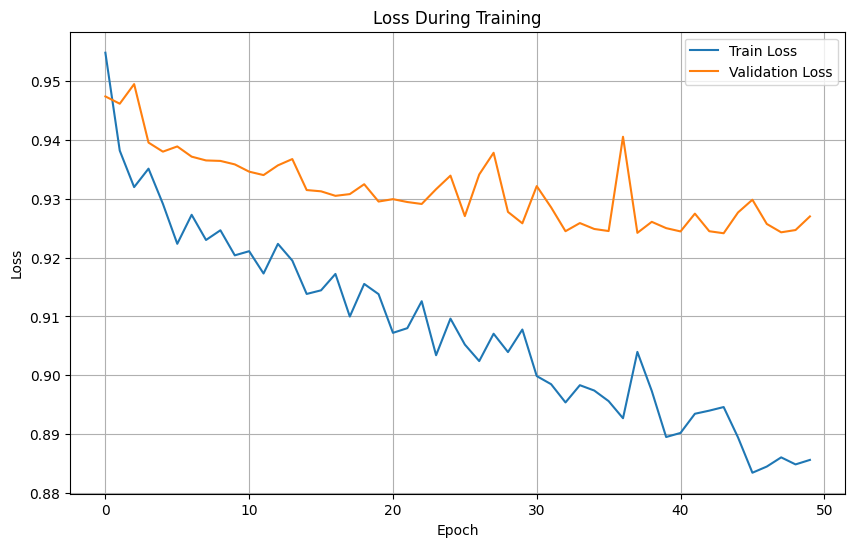


Evaluating on Validation set...


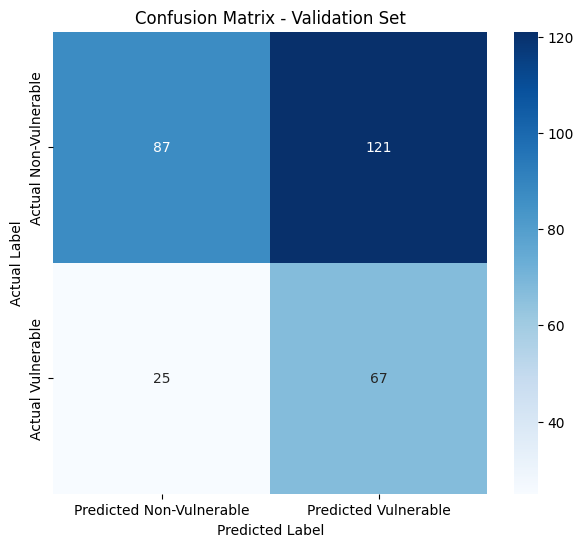

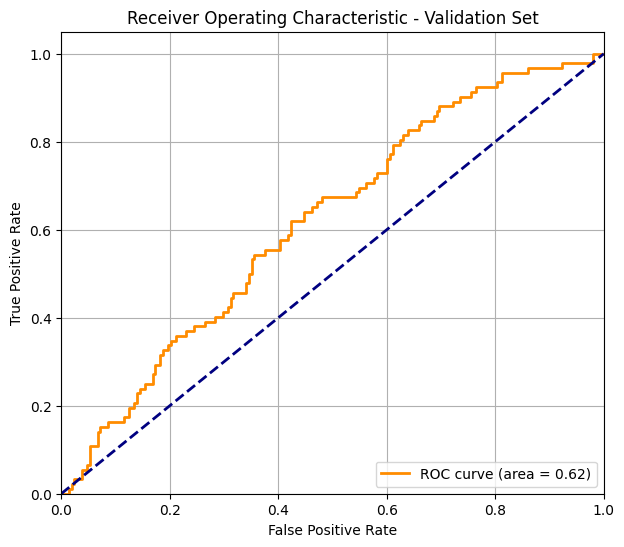


Evaluating on Test set...


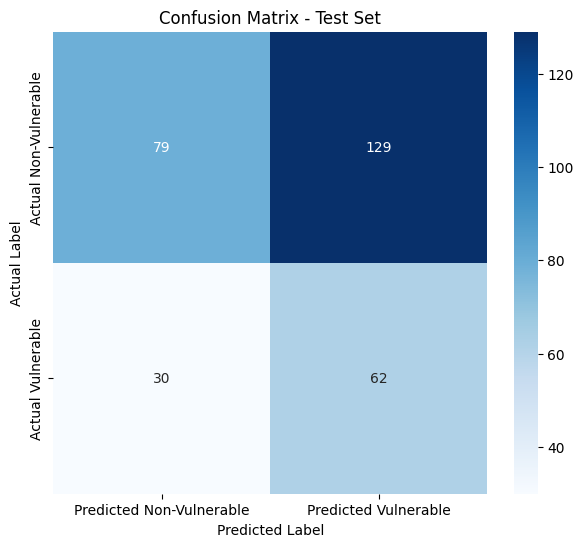

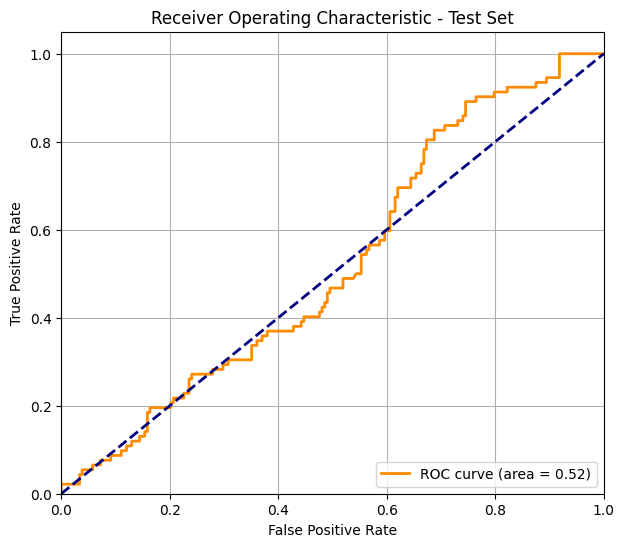


--- Validation Set Evaluation Results ---
Precision: 0.3564
Recall: 0.7283
F1-Score: 0.4786
Accuracy: 0.5133
ROC-AUC: 0.6185

--- Test Set Evaluation Results ---
Precision: 0.3246
Recall: 0.6739
F1-Score: 0.4382
Accuracy: 0.4700
ROC-AUC: 0.5216


In [16]:
num_epochs = 50
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print("\nEvaluating on Validation set...")
precision_v, recall_v, f1_v, accuracy_v, roc_auc_v = evaluate_model(model, val_loader, set_name="Validation")

print("\nEvaluating on Test set...")
precision_t, recall_t, f1_t, accuracy_t, roc_auc_t = evaluate_model(model, test_loader, set_name="Test")

print(f"\n--- Validation Set Evaluation Results ---")
print(f"Precision: {precision_v:.4f}")
print(f"Recall: {recall_v:.4f}")
print(f"F1-Score: {f1_v:.4f}")
print(f"Accuracy: {accuracy_v:.4f}")
print(f"ROC-AUC: {roc_auc_v:.4f}")

print(f"\n--- Test Set Evaluation Results ---")
print(f"Precision: {precision_t:.4f}")
print(f"Recall: {recall_t:.4f}")
print(f"F1-Score: {f1_t:.4f}")
print(f"Accuracy: {accuracy_t:.4f}")
print(f"ROC-AUC: {roc_auc_t:.4f}")

#**Enhanced Model**

In [52]:
def train_enhanced_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, patience=5):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                model.load_state_dict(best_model_state)
                break


        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
    return train_losses, val_losses

In [53]:
def evaluate_enhanced_model_iter(model, data_loader, set_name="Test", threshold=0.5):
    model.eval()
    all_predictions = []
    all_probabilities = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs).cpu()
            predicted = (probs > threshold).float()
            all_predictions.extend(predicted.numpy())
            all_probabilities.extend(probs.numpy())
            all_labels.extend(labels.numpy())

    all_predictions = np.array(all_predictions).flatten()
    all_probabilities = np.array(all_probabilities).flatten()
    all_labels = np.array(all_labels).flatten()

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='binary', zero_division=0)
    accuracy = accuracy_score(all_labels, all_predictions)
    try:
        roc_auc = roc_auc_score(all_labels, all_probabilities)
    except ValueError:
        roc_auc = 0.0

    return precision, recall, f1, accuracy, roc_auc

### Hyperparameters search

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from tqdm import tqdm


class MLPClassifierEnhanced(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.classifier(x)

results = []

input_dim = X_train.shape[1]
num_epochs = 100

for seed in tqdm(range(51), desc="Running seeds 0 to 50"):
    set_seed(seed)

    model = MLPClassifierEnhanced(input_dim).to(device)

    pos_weight = torch.tensor([len(y_train) / y_train.sum() - 1]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    train_losses, val_losses = train_enhanced_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)

    # Evaluate on validation set
    precision_v, recall_v, f1_v, acc_v, roc_auc_v = evaluate_enhanced_model_iter(model, val_loader, set_name="Validation")

    # Evaluate on test set
    precision_t, recall_t, f1_t, acc_t, roc_auc_t = evaluate_enhanced_model_iter(model, test_loader, set_name="Test")

    results.append({
        "Seed": seed,
        "Val_Precision": precision_v,
        "Val_Recall": recall_v,
        "Val_F1": f1_v,
        "Val_Accuracy": acc_v,
        "Val_ROC_AUC": roc_auc_v,
        "Test_Precision": precision_t,
        "Test_Recall": recall_t,
        "Test_F1": f1_t,
        "Test_Accuracy": acc_t,
        "Test_ROC_AUC": roc_auc_t
    })


results_df = pd.DataFrame(results)


pd.set_option("display.max_columns", None)
print(results_df)

Running seeds 0 to 50:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 1/100 - Train Loss: 0.9475, Val Loss: 0.9410
Epoch 2/100 - Train Loss: 0.9341, Val Loss: 0.9581
Epoch 3/100 - Train Loss: 0.9220, Val Loss: 0.9385
Epoch 4/100 - Train Loss: 0.8992, Val Loss: 0.9355
Epoch 5/100 - Train Loss: 0.8939, Val Loss: 0.9353
Epoch 6/100 - Train Loss: 0.8756, Val Loss: 0.9281
Epoch 7/100 - Train Loss: 0.8726, Val Loss: 0.9287
Epoch 8/100 - Train Loss: 0.8719, Val Loss: 0.9423
Epoch 9/100 - Train Loss: 0.8648, Val Loss: 0.9560
Epoch 10/100 - Train Loss: 0.8516, Val Loss: 0.9250
Epoch 11/100 - Train Loss: 0.8576, Val Loss: 0.9241
Epoch 12/100 - Train Loss: 0.8375, Val Loss: 0.9152
Epoch 13/100 - Train Loss: 0.8216, Val Loss: 0.9233
Epoch 14/100 - Train Loss: 0.8308, Val Loss: 0.9401
Epoch 15/100 - Train Loss: 0.7889, Val Loss: 0.9297
Epoch 16/100 - Train Loss: 0.8035, Val Loss: 0.9283


Running seeds 0 to 50:   2%|▏         | 1/51 [00:02<01:46,  2.14s/it]

Early stopping at epoch 17
Epoch 1/100 - Train Loss: 0.9448, Val Loss: 0.9518
Epoch 2/100 - Train Loss: 0.9248, Val Loss: 0.9522
Epoch 3/100 - Train Loss: 0.9073, Val Loss: 0.9341
Epoch 4/100 - Train Loss: 0.8884, Val Loss: 0.9316
Epoch 5/100 - Train Loss: 0.8891, Val Loss: 0.9712
Epoch 6/100 - Train Loss: 0.8683, Val Loss: 0.9315
Epoch 7/100 - Train Loss: 0.8699, Val Loss: 0.9246
Epoch 8/100 - Train Loss: 0.8612, Val Loss: 0.9349
Epoch 9/100 - Train Loss: 0.8483, Val Loss: 0.9266
Epoch 10/100 - Train Loss: 0.8427, Val Loss: 0.9314
Epoch 11/100 - Train Loss: 0.8484, Val Loss: 0.9313


Running seeds 0 to 50:   4%|▍         | 2/51 [00:03<01:26,  1.76s/it]

Early stopping at epoch 12
Epoch 1/100 - Train Loss: 0.9641, Val Loss: 0.9411
Epoch 2/100 - Train Loss: 0.9344, Val Loss: 0.9427
Epoch 3/100 - Train Loss: 0.9121, Val Loss: 0.9386
Epoch 4/100 - Train Loss: 0.9124, Val Loss: 0.9352
Epoch 5/100 - Train Loss: 0.8825, Val Loss: 0.9302
Epoch 6/100 - Train Loss: 0.8787, Val Loss: 0.9317
Epoch 7/100 - Train Loss: 0.8762, Val Loss: 0.9593
Epoch 8/100 - Train Loss: 0.8771, Val Loss: 0.9316
Epoch 9/100 - Train Loss: 0.8714, Val Loss: 0.9335
Epoch 10/100 - Train Loss: 0.8456, Val Loss: 0.9224
Epoch 11/100 - Train Loss: 0.8430, Val Loss: 0.9215
Epoch 12/100 - Train Loss: 0.8456, Val Loss: 0.9334
Epoch 13/100 - Train Loss: 0.8231, Val Loss: 0.9261
Epoch 14/100 - Train Loss: 0.8256, Val Loss: 0.9296
Epoch 15/100 - Train Loss: 0.8086, Val Loss: 0.9341


Running seeds 0 to 50:   6%|▌         | 3/51 [00:05<01:28,  1.84s/it]

Early stopping at epoch 16
Epoch 1/100 - Train Loss: 0.9739, Val Loss: 0.9364
Epoch 2/100 - Train Loss: 0.9262, Val Loss: 0.9287
Epoch 3/100 - Train Loss: 0.9092, Val Loss: 0.9313
Epoch 4/100 - Train Loss: 0.9079, Val Loss: 0.9347
Epoch 5/100 - Train Loss: 0.8989, Val Loss: 0.9269
Epoch 6/100 - Train Loss: 0.8849, Val Loss: 0.9261
Epoch 7/100 - Train Loss: 0.8824, Val Loss: 0.9217
Epoch 8/100 - Train Loss: 0.8721, Val Loss: 0.9222
Epoch 9/100 - Train Loss: 0.8629, Val Loss: 0.9268
Epoch 10/100 - Train Loss: 0.8492, Val Loss: 0.9478
Epoch 11/100 - Train Loss: 0.8528, Val Loss: 0.9184
Epoch 12/100 - Train Loss: 0.8438, Val Loss: 0.9270
Epoch 13/100 - Train Loss: 0.8321, Val Loss: 0.9308
Epoch 14/100 - Train Loss: 0.8268, Val Loss: 1.0036
Epoch 15/100 - Train Loss: 0.8222, Val Loss: 0.9219


Running seeds 0 to 50:   8%|▊         | 4/51 [00:07<01:28,  1.88s/it]

Early stopping at epoch 16
Epoch 1/100 - Train Loss: 0.9503, Val Loss: 0.9527
Epoch 2/100 - Train Loss: 0.9314, Val Loss: 0.9480
Epoch 3/100 - Train Loss: 0.9101, Val Loss: 0.9411
Epoch 4/100 - Train Loss: 0.8969, Val Loss: 0.9391
Epoch 5/100 - Train Loss: 0.8834, Val Loss: 0.9456
Epoch 6/100 - Train Loss: 0.8824, Val Loss: 0.9343
Epoch 7/100 - Train Loss: 0.8764, Val Loss: 0.9418
Epoch 8/100 - Train Loss: 0.8659, Val Loss: 0.9272
Epoch 9/100 - Train Loss: 0.8582, Val Loss: 0.9335
Epoch 10/100 - Train Loss: 0.8514, Val Loss: 0.9386
Epoch 11/100 - Train Loss: 0.8486, Val Loss: 0.9304


Running seeds 0 to 50:  10%|▉         | 5/51 [00:09<01:28,  1.92s/it]

Epoch 12/100 - Train Loss: 0.8263, Val Loss: 0.9436
Early stopping at epoch 13
Epoch 1/100 - Train Loss: 0.9743, Val Loss: 0.9493
Epoch 2/100 - Train Loss: 0.9346, Val Loss: 0.9404
Epoch 3/100 - Train Loss: 0.9158, Val Loss: 0.9334
Epoch 4/100 - Train Loss: 0.9031, Val Loss: 0.9366
Epoch 5/100 - Train Loss: 0.8858, Val Loss: 0.9359
Epoch 6/100 - Train Loss: 0.8835, Val Loss: 0.9309
Epoch 7/100 - Train Loss: 0.8838, Val Loss: 0.9300
Epoch 8/100 - Train Loss: 0.8693, Val Loss: 0.9304
Epoch 9/100 - Train Loss: 0.8557, Val Loss: 0.9318
Epoch 10/100 - Train Loss: 0.8557, Val Loss: 0.9402
Epoch 11/100 - Train Loss: 0.8410, Val Loss: 0.9346
Epoch 12/100 - Train Loss: 0.8437, Val Loss: 0.9278
Epoch 13/100 - Train Loss: 0.8261, Val Loss: 0.9229
Epoch 14/100 - Train Loss: 0.8281, Val Loss: 0.9487
Epoch 15/100 - Train Loss: 0.8209, Val Loss: 0.9695
Epoch 16/100 - Train Loss: 0.8040, Val Loss: 0.9233


Running seeds 0 to 50:  12%|█▏        | 6/51 [00:11<01:33,  2.07s/it]

Epoch 17/100 - Train Loss: 0.8066, Val Loss: 1.0044
Early stopping at epoch 18
Epoch 1/100 - Train Loss: 0.9601, Val Loss: 0.9544
Epoch 2/100 - Train Loss: 0.9198, Val Loss: 0.9608
Epoch 3/100 - Train Loss: 0.9161, Val Loss: 0.9328
Epoch 4/100 - Train Loss: 0.8917, Val Loss: 0.9394
Epoch 5/100 - Train Loss: 0.8898, Val Loss: 0.9286
Epoch 6/100 - Train Loss: 0.8780, Val Loss: 0.9385
Epoch 7/100 - Train Loss: 0.8879, Val Loss: 0.9330
Epoch 8/100 - Train Loss: 0.8627, Val Loss: 0.9234
Epoch 9/100 - Train Loss: 0.8475, Val Loss: 0.9421
Epoch 10/100 - Train Loss: 0.8547, Val Loss: 0.9369
Epoch 11/100 - Train Loss: 0.8391, Val Loss: 0.9302
Epoch 12/100 - Train Loss: 0.8398, Val Loss: 0.9447


Running seeds 0 to 50:  14%|█▎        | 7/51 [00:13<01:24,  1.91s/it]

Early stopping at epoch 13
Epoch 1/100 - Train Loss: 1.0179, Val Loss: 0.9675
Epoch 2/100 - Train Loss: 0.9744, Val Loss: 0.9689
Epoch 3/100 - Train Loss: 0.9425, Val Loss: 0.9805
Epoch 4/100 - Train Loss: 0.9288, Val Loss: 0.9344
Epoch 5/100 - Train Loss: 0.9039, Val Loss: 0.9740
Epoch 6/100 - Train Loss: 0.9057, Val Loss: 0.9473
Epoch 7/100 - Train Loss: 0.8849, Val Loss: 0.9399
Epoch 8/100 - Train Loss: 0.8813, Val Loss: 0.9384
Epoch 9/100 - Train Loss: 0.8742, Val Loss: 0.9307
Epoch 10/100 - Train Loss: 0.8577, Val Loss: 0.9324
Epoch 11/100 - Train Loss: 0.8540, Val Loss: 0.9400
Epoch 12/100 - Train Loss: 0.8720, Val Loss: 0.9397
Epoch 13/100 - Train Loss: 0.8383, Val Loss: 0.9370


Running seeds 0 to 50:  16%|█▌        | 8/51 [00:15<01:19,  1.86s/it]

Early stopping at epoch 14
Epoch 1/100 - Train Loss: 0.9458, Val Loss: 0.9481
Epoch 2/100 - Train Loss: 0.9221, Val Loss: 0.9421
Epoch 3/100 - Train Loss: 0.9101, Val Loss: 0.9406
Epoch 4/100 - Train Loss: 0.8887, Val Loss: 0.9315
Epoch 5/100 - Train Loss: 0.8997, Val Loss: 0.9362
Epoch 6/100 - Train Loss: 0.8821, Val Loss: 0.9376
Epoch 7/100 - Train Loss: 0.8799, Val Loss: 0.9269
Epoch 8/100 - Train Loss: 0.8589, Val Loss: 0.9347
Epoch 9/100 - Train Loss: 0.8620, Val Loss: 0.9348
Epoch 10/100 - Train Loss: 0.8446, Val Loss: 0.9280
Epoch 11/100 - Train Loss: 0.8280, Val Loss: 0.9440


Running seeds 0 to 50:  18%|█▊        | 9/51 [00:16<01:13,  1.75s/it]

Early stopping at epoch 12
Epoch 1/100 - Train Loss: 0.9545, Val Loss: 0.9386
Epoch 2/100 - Train Loss: 0.9405, Val Loss: 0.9339
Epoch 3/100 - Train Loss: 0.9202, Val Loss: 0.9264
Epoch 4/100 - Train Loss: 0.8929, Val Loss: 0.9416
Epoch 5/100 - Train Loss: 0.9024, Val Loss: 0.9282
Epoch 6/100 - Train Loss: 0.8852, Val Loss: 0.9243
Epoch 7/100 - Train Loss: 0.8822, Val Loss: 0.9267
Epoch 8/100 - Train Loss: 0.8725, Val Loss: 0.9271
Epoch 9/100 - Train Loss: 0.8647, Val Loss: 0.9315
Epoch 10/100 - Train Loss: 0.8679, Val Loss: 0.9229
Epoch 11/100 - Train Loss: 0.8416, Val Loss: 0.9357
Epoch 12/100 - Train Loss: 0.8420, Val Loss: 0.9214
Epoch 13/100 - Train Loss: 0.8242, Val Loss: 0.9195
Epoch 14/100 - Train Loss: 0.8205, Val Loss: 0.9297
Epoch 15/100 - Train Loss: 0.8265, Val Loss: 0.9178
Epoch 16/100 - Train Loss: 0.8094, Val Loss: 0.9344
Epoch 17/100 - Train Loss: 0.7975, Val Loss: 0.9167
Epoch 18/100 - Train Loss: 0.8016, Val Loss: 0.9711
Epoch 19/100 - Train Loss: 0.7910, Val Loss: 0

Running seeds 0 to 50:  20%|█▉        | 10/51 [00:19<01:23,  2.04s/it]

Early stopping at epoch 22
Epoch 1/100 - Train Loss: 0.9662, Val Loss: 0.9581
Epoch 2/100 - Train Loss: 0.9260, Val Loss: 0.9466
Epoch 3/100 - Train Loss: 0.9098, Val Loss: 0.9376
Epoch 4/100 - Train Loss: 0.9004, Val Loss: 0.9372
Epoch 5/100 - Train Loss: 0.8887, Val Loss: 0.9437
Epoch 6/100 - Train Loss: 0.8779, Val Loss: 0.9427
Epoch 7/100 - Train Loss: 0.8756, Val Loss: 0.9315
Epoch 8/100 - Train Loss: 0.8641, Val Loss: 0.9410
Epoch 9/100 - Train Loss: 0.8508, Val Loss: 0.9422
Epoch 10/100 - Train Loss: 0.8411, Val Loss: 0.9363
Epoch 11/100 - Train Loss: 0.8358, Val Loss: 0.9413
Epoch 12/100 - Train Loss: 0.8385, Val Loss: 0.9197
Epoch 13/100 - Train Loss: 0.8274, Val Loss: 0.9410
Epoch 14/100 - Train Loss: 0.8278, Val Loss: 0.9307
Epoch 15/100 - Train Loss: 0.7938, Val Loss: 0.9419


Running seeds 0 to 50:  22%|██▏       | 11/51 [00:21<01:28,  2.21s/it]

Epoch 16/100 - Train Loss: 0.8046, Val Loss: 0.9849
Early stopping at epoch 17
Epoch 1/100 - Train Loss: 0.9561, Val Loss: 0.9344
Epoch 2/100 - Train Loss: 0.9185, Val Loss: 0.9482
Epoch 3/100 - Train Loss: 0.9228, Val Loss: 0.9308
Epoch 4/100 - Train Loss: 0.9093, Val Loss: 0.9268
Epoch 5/100 - Train Loss: 0.8823, Val Loss: 0.9229
Epoch 6/100 - Train Loss: 0.8919, Val Loss: 0.9309
Epoch 7/100 - Train Loss: 0.8877, Val Loss: 0.9352
Epoch 8/100 - Train Loss: 0.8691, Val Loss: 0.9220
Epoch 9/100 - Train Loss: 0.8576, Val Loss: 0.9578
Epoch 10/100 - Train Loss: 0.8501, Val Loss: 0.9215
Epoch 11/100 - Train Loss: 0.8566, Val Loss: 0.9222
Epoch 12/100 - Train Loss: 0.8375, Val Loss: 0.9285
Epoch 13/100 - Train Loss: 0.8329, Val Loss: 0.9368
Epoch 14/100 - Train Loss: 0.8142, Val Loss: 0.9197
Epoch 15/100 - Train Loss: 0.8278, Val Loss: 0.9246
Epoch 16/100 - Train Loss: 0.7971, Val Loss: 0.9279
Epoch 17/100 - Train Loss: 0.8104, Val Loss: 0.9458
Epoch 18/100 - Train Loss: 0.8121, Val Loss: 0

Running seeds 0 to 50:  24%|██▎       | 12/51 [00:24<01:27,  2.24s/it]

Early stopping at epoch 19
Epoch 1/100 - Train Loss: 0.9614, Val Loss: 0.9517
Epoch 2/100 - Train Loss: 0.9289, Val Loss: 0.9478
Epoch 3/100 - Train Loss: 0.9135, Val Loss: 0.9489
Epoch 4/100 - Train Loss: 0.9173, Val Loss: 0.9358
Epoch 5/100 - Train Loss: 0.8900, Val Loss: 0.9379
Epoch 6/100 - Train Loss: 0.8852, Val Loss: 0.9378
Epoch 7/100 - Train Loss: 0.8806, Val Loss: 0.9313
Epoch 8/100 - Train Loss: 0.8778, Val Loss: 0.9391
Epoch 9/100 - Train Loss: 0.8717, Val Loss: 0.9334
Epoch 10/100 - Train Loss: 0.8452, Val Loss: 0.9300
Epoch 11/100 - Train Loss: 0.8534, Val Loss: 0.9339
Epoch 12/100 - Train Loss: 0.8299, Val Loss: 0.9346
Epoch 13/100 - Train Loss: 0.8399, Val Loss: 0.9380
Epoch 14/100 - Train Loss: 0.8264, Val Loss: 0.9301
Epoch 15/100 - Train Loss: 0.8104, Val Loss: 0.9214
Epoch 16/100 - Train Loss: 0.8167, Val Loss: 0.9638
Epoch 17/100 - Train Loss: 0.8222, Val Loss: 0.9326
Epoch 18/100 - Train Loss: 0.7941, Val Loss: 0.9316
Epoch 19/100 - Train Loss: 0.7908, Val Loss: 0

Running seeds 0 to 50:  25%|██▌       | 13/51 [00:26<01:27,  2.31s/it]

Early stopping at epoch 20
Epoch 1/100 - Train Loss: 0.9670, Val Loss: 0.9523
Epoch 2/100 - Train Loss: 0.9359, Val Loss: 0.9411
Epoch 3/100 - Train Loss: 0.9139, Val Loss: 0.9345
Epoch 4/100 - Train Loss: 0.9097, Val Loss: 0.9268
Epoch 5/100 - Train Loss: 0.8837, Val Loss: 0.9320
Epoch 6/100 - Train Loss: 0.8842, Val Loss: 0.9323
Epoch 7/100 - Train Loss: 0.8766, Val Loss: 0.9242
Epoch 8/100 - Train Loss: 0.8731, Val Loss: 0.9107
Epoch 9/100 - Train Loss: 0.8548, Val Loss: 0.9255
Epoch 10/100 - Train Loss: 0.8536, Val Loss: 0.9178
Epoch 11/100 - Train Loss: 0.8457, Val Loss: 0.9202


Running seeds 0 to 50:  27%|██▋       | 14/51 [00:28<01:17,  2.09s/it]

Epoch 12/100 - Train Loss: 0.8331, Val Loss: 0.9129
Early stopping at epoch 13
Epoch 1/100 - Train Loss: 0.9556, Val Loss: 0.9492
Epoch 2/100 - Train Loss: 0.9195, Val Loss: 0.9351
Epoch 3/100 - Train Loss: 0.9029, Val Loss: 0.9388
Epoch 4/100 - Train Loss: 0.9207, Val Loss: 0.9373
Epoch 5/100 - Train Loss: 0.8865, Val Loss: 0.9392
Epoch 6/100 - Train Loss: 0.8863, Val Loss: 0.9391


Running seeds 0 to 50:  29%|██▉       | 15/51 [00:29<01:02,  1.73s/it]

Early stopping at epoch 7
Epoch 1/100 - Train Loss: 1.0148, Val Loss: 0.9712
Epoch 2/100 - Train Loss: 0.9628, Val Loss: 0.9561
Epoch 3/100 - Train Loss: 0.9522, Val Loss: 0.9688
Epoch 4/100 - Train Loss: 0.9279, Val Loss: 0.9516
Epoch 5/100 - Train Loss: 0.9092, Val Loss: 0.9284
Epoch 6/100 - Train Loss: 0.8990, Val Loss: 0.9554
Epoch 7/100 - Train Loss: 0.8893, Val Loss: 0.9277
Epoch 8/100 - Train Loss: 0.8883, Val Loss: 0.9241
Epoch 9/100 - Train Loss: 0.8820, Val Loss: 0.9363
Epoch 10/100 - Train Loss: 0.8594, Val Loss: 0.9234
Epoch 11/100 - Train Loss: 0.8482, Val Loss: 0.9701
Epoch 12/100 - Train Loss: 0.8409, Val Loss: 0.9267
Epoch 13/100 - Train Loss: 0.8354, Val Loss: 0.9222
Epoch 14/100 - Train Loss: 0.8137, Val Loss: 0.9405
Epoch 15/100 - Train Loss: 0.8282, Val Loss: 0.9237
Epoch 16/100 - Train Loss: 0.8265, Val Loss: 0.9256
Epoch 17/100 - Train Loss: 0.8033, Val Loss: 0.9255


Running seeds 0 to 50:  31%|███▏      | 16/51 [00:31<01:05,  1.87s/it]

Early stopping at epoch 18
Epoch 1/100 - Train Loss: 0.9710, Val Loss: 0.9439
Epoch 2/100 - Train Loss: 0.9148, Val Loss: 0.9434
Epoch 3/100 - Train Loss: 0.9110, Val Loss: 0.9497
Epoch 4/100 - Train Loss: 0.8957, Val Loss: 0.9380
Epoch 5/100 - Train Loss: 0.8944, Val Loss: 0.9399
Epoch 6/100 - Train Loss: 0.8812, Val Loss: 0.9414
Epoch 7/100 - Train Loss: 0.8718, Val Loss: 0.9383
Epoch 8/100 - Train Loss: 0.8666, Val Loss: 0.9325
Epoch 9/100 - Train Loss: 0.8686, Val Loss: 0.9284
Epoch 10/100 - Train Loss: 0.8512, Val Loss: 0.9350
Epoch 11/100 - Train Loss: 0.8549, Val Loss: 0.9370
Epoch 12/100 - Train Loss: 0.8296, Val Loss: 0.9407
Epoch 13/100 - Train Loss: 0.8149, Val Loss: 0.9503


Running seeds 0 to 50:  33%|███▎      | 17/51 [00:33<01:05,  1.94s/it]

Early stopping at epoch 14
Epoch 1/100 - Train Loss: 0.9570, Val Loss: 0.9518
Epoch 2/100 - Train Loss: 0.9231, Val Loss: 0.9388
Epoch 3/100 - Train Loss: 0.9078, Val Loss: 0.9346
Epoch 4/100 - Train Loss: 0.9045, Val Loss: 0.9360
Epoch 5/100 - Train Loss: 0.8952, Val Loss: 0.9306
Epoch 6/100 - Train Loss: 0.8962, Val Loss: 0.9265
Epoch 7/100 - Train Loss: 0.8861, Val Loss: 0.9275
Epoch 8/100 - Train Loss: 0.8630, Val Loss: 0.9303
Epoch 9/100 - Train Loss: 0.8544, Val Loss: 0.9210
Epoch 10/100 - Train Loss: 0.8577, Val Loss: 0.9553
Epoch 11/100 - Train Loss: 0.8365, Val Loss: 0.9192
Epoch 12/100 - Train Loss: 0.8435, Val Loss: 0.9210
Epoch 13/100 - Train Loss: 0.8333, Val Loss: 0.9339
Epoch 14/100 - Train Loss: 0.8264, Val Loss: 0.9269


Running seeds 0 to 50:  35%|███▌      | 18/51 [00:35<01:05,  2.00s/it]

Epoch 15/100 - Train Loss: 0.8112, Val Loss: 0.9299
Early stopping at epoch 16
Epoch 1/100 - Train Loss: 0.9755, Val Loss: 0.9446
Epoch 2/100 - Train Loss: 0.9279, Val Loss: 0.9575
Epoch 3/100 - Train Loss: 0.9153, Val Loss: 0.9467
Epoch 4/100 - Train Loss: 0.9113, Val Loss: 0.9428
Epoch 5/100 - Train Loss: 0.9050, Val Loss: 0.9507
Epoch 6/100 - Train Loss: 0.8871, Val Loss: 0.9456
Epoch 7/100 - Train Loss: 0.8774, Val Loss: 0.9346
Epoch 8/100 - Train Loss: 0.8631, Val Loss: 0.9311
Epoch 9/100 - Train Loss: 0.8536, Val Loss: 0.9280
Epoch 10/100 - Train Loss: 0.8479, Val Loss: 0.9351
Epoch 11/100 - Train Loss: 0.8356, Val Loss: 0.9392
Epoch 12/100 - Train Loss: 0.8488, Val Loss: 1.0012


Running seeds 0 to 50:  37%|███▋      | 19/51 [00:37<01:01,  1.92s/it]

Epoch 13/100 - Train Loss: 0.8319, Val Loss: 0.9416
Early stopping at epoch 14
Epoch 1/100 - Train Loss: 0.9424, Val Loss: 0.9393
Epoch 2/100 - Train Loss: 0.9217, Val Loss: 0.9359
Epoch 3/100 - Train Loss: 0.9180, Val Loss: 0.9311
Epoch 4/100 - Train Loss: 0.8879, Val Loss: 0.9371
Epoch 5/100 - Train Loss: 0.8783, Val Loss: 0.9270
Epoch 6/100 - Train Loss: 0.8897, Val Loss: 0.9312
Epoch 7/100 - Train Loss: 0.8707, Val Loss: 0.9293
Epoch 8/100 - Train Loss: 0.8547, Val Loss: 0.9389


Running seeds 0 to 50:  39%|███▉      | 20/51 [00:38<00:53,  1.71s/it]

Epoch 9/100 - Train Loss: 0.8515, Val Loss: 0.9381
Early stopping at epoch 10
Epoch 1/100 - Train Loss: 0.9463, Val Loss: 0.9475
Epoch 2/100 - Train Loss: 0.9252, Val Loss: 0.9448
Epoch 3/100 - Train Loss: 0.9130, Val Loss: 0.9437
Epoch 4/100 - Train Loss: 0.9072, Val Loss: 0.9453
Epoch 5/100 - Train Loss: 0.8924, Val Loss: 0.9399
Epoch 6/100 - Train Loss: 0.8759, Val Loss: 0.9487
Epoch 7/100 - Train Loss: 0.8835, Val Loss: 0.9384
Epoch 8/100 - Train Loss: 0.8692, Val Loss: 0.9310
Epoch 9/100 - Train Loss: 0.8716, Val Loss: 0.9223
Epoch 10/100 - Train Loss: 0.8542, Val Loss: 0.9285
Epoch 11/100 - Train Loss: 0.8427, Val Loss: 0.9312
Epoch 12/100 - Train Loss: 0.8352, Val Loss: 0.9386


Running seeds 0 to 50:  41%|████      | 21/51 [00:40<00:51,  1.71s/it]

Epoch 13/100 - Train Loss: 0.8432, Val Loss: 0.9296
Early stopping at epoch 14
Epoch 1/100 - Train Loss: 0.9750, Val Loss: 0.9463
Epoch 2/100 - Train Loss: 0.9260, Val Loss: 0.9370
Epoch 3/100 - Train Loss: 0.9268, Val Loss: 0.9434
Epoch 4/100 - Train Loss: 0.8996, Val Loss: 0.9273
Epoch 5/100 - Train Loss: 0.8985, Val Loss: 0.9288
Epoch 6/100 - Train Loss: 0.8848, Val Loss: 0.9283
Epoch 7/100 - Train Loss: 0.8560, Val Loss: 0.9261
Epoch 8/100 - Train Loss: 0.8599, Val Loss: 0.9156
Epoch 9/100 - Train Loss: 0.8449, Val Loss: 0.9266
Epoch 10/100 - Train Loss: 0.8406, Val Loss: 0.9271
Epoch 11/100 - Train Loss: 0.8466, Val Loss: 0.9269
Epoch 12/100 - Train Loss: 0.8268, Val Loss: 0.9143
Epoch 13/100 - Train Loss: 0.8201, Val Loss: 0.9299
Epoch 14/100 - Train Loss: 0.8040, Val Loss: 0.9394
Epoch 15/100 - Train Loss: 0.7929, Val Loss: 0.9176
Epoch 16/100 - Train Loss: 0.8017, Val Loss: 0.9198


Running seeds 0 to 50:  43%|████▎     | 22/51 [00:42<00:52,  1.82s/it]

Early stopping at epoch 17
Epoch 1/100 - Train Loss: 0.9398, Val Loss: 0.9421
Epoch 2/100 - Train Loss: 0.9239, Val Loss: 0.9265
Epoch 3/100 - Train Loss: 0.9041, Val Loss: 0.9318
Epoch 4/100 - Train Loss: 0.8899, Val Loss: 0.9321
Epoch 5/100 - Train Loss: 0.8971, Val Loss: 0.9248
Epoch 6/100 - Train Loss: 0.8647, Val Loss: 0.9273
Epoch 7/100 - Train Loss: 0.8655, Val Loss: 0.9408
Epoch 8/100 - Train Loss: 0.8495, Val Loss: 0.9296
Epoch 9/100 - Train Loss: 0.8587, Val Loss: 0.9241
Epoch 10/100 - Train Loss: 0.8422, Val Loss: 0.9295
Epoch 11/100 - Train Loss: 0.8341, Val Loss: 0.9289
Epoch 12/100 - Train Loss: 0.8308, Val Loss: 0.9299
Epoch 13/100 - Train Loss: 0.8256, Val Loss: 0.9294
Epoch 14/100 - Train Loss: 0.8148, Val Loss: 0.9232
Epoch 15/100 - Train Loss: 0.7994, Val Loss: 0.9393
Epoch 16/100 - Train Loss: 0.7904, Val Loss: 0.9324
Epoch 17/100 - Train Loss: 0.7937, Val Loss: 0.9366
Epoch 18/100 - Train Loss: 0.7822, Val Loss: 0.9187
Epoch 19/100 - Train Loss: 0.7738, Val Loss: 0

Running seeds 0 to 50:  45%|████▌     | 23/51 [00:45<01:01,  2.21s/it]

Epoch 22/100 - Train Loss: 0.7643, Val Loss: 0.9997
Early stopping at epoch 23
Epoch 1/100 - Train Loss: 0.9638, Val Loss: 0.9415
Epoch 2/100 - Train Loss: 0.9260, Val Loss: 0.9446
Epoch 3/100 - Train Loss: 0.9096, Val Loss: 0.9302
Epoch 4/100 - Train Loss: 0.8877, Val Loss: 0.9229
Epoch 5/100 - Train Loss: 0.8994, Val Loss: 0.9235
Epoch 6/100 - Train Loss: 0.8747, Val Loss: 0.9204
Epoch 7/100 - Train Loss: 0.8570, Val Loss: 0.9258
Epoch 8/100 - Train Loss: 0.8695, Val Loss: 0.9147
Epoch 9/100 - Train Loss: 0.8574, Val Loss: 0.9229
Epoch 10/100 - Train Loss: 0.8478, Val Loss: 0.9258
Epoch 11/100 - Train Loss: 0.8416, Val Loss: 0.9199
Epoch 12/100 - Train Loss: 0.8400, Val Loss: 0.9246


Running seeds 0 to 50:  47%|████▋     | 24/51 [00:47<00:56,  2.09s/it]

Early stopping at epoch 13
Epoch 1/100 - Train Loss: 0.9377, Val Loss: 0.9359
Epoch 2/100 - Train Loss: 0.9274, Val Loss: 0.9359
Epoch 3/100 - Train Loss: 0.9142, Val Loss: 0.9339
Epoch 4/100 - Train Loss: 0.8989, Val Loss: 0.9326
Epoch 5/100 - Train Loss: 0.8889, Val Loss: 0.9264
Epoch 6/100 - Train Loss: 0.8793, Val Loss: 0.9311
Epoch 7/100 - Train Loss: 0.8693, Val Loss: 0.9359
Epoch 8/100 - Train Loss: 0.8590, Val Loss: 0.9331
Epoch 9/100 - Train Loss: 0.8483, Val Loss: 0.9244
Epoch 10/100 - Train Loss: 0.8418, Val Loss: 0.9169
Epoch 11/100 - Train Loss: 0.8397, Val Loss: 0.9300
Epoch 12/100 - Train Loss: 0.8374, Val Loss: 0.9285
Epoch 13/100 - Train Loss: 0.8263, Val Loss: 0.9192


Running seeds 0 to 50:  49%|████▉     | 25/51 [00:49<00:52,  2.02s/it]

Epoch 14/100 - Train Loss: 0.8303, Val Loss: 0.9379
Early stopping at epoch 15
Epoch 1/100 - Train Loss: 0.9802, Val Loss: 0.9475
Epoch 2/100 - Train Loss: 0.9555, Val Loss: 0.9478
Epoch 3/100 - Train Loss: 0.9352, Val Loss: 0.9679
Epoch 4/100 - Train Loss: 0.9216, Val Loss: 0.9397
Epoch 5/100 - Train Loss: 0.9204, Val Loss: 0.9335
Epoch 6/100 - Train Loss: 0.8929, Val Loss: 0.9327
Epoch 7/100 - Train Loss: 0.8844, Val Loss: 0.9420
Epoch 8/100 - Train Loss: 0.8772, Val Loss: 0.9255
Epoch 9/100 - Train Loss: 0.8647, Val Loss: 0.9235
Epoch 10/100 - Train Loss: 0.8492, Val Loss: 0.9365
Epoch 11/100 - Train Loss: 0.8478, Val Loss: 0.9285
Epoch 12/100 - Train Loss: 0.8534, Val Loss: 0.9285


Running seeds 0 to 50:  51%|█████     | 26/51 [00:50<00:48,  1.93s/it]

Epoch 13/100 - Train Loss: 0.8298, Val Loss: 0.9285
Early stopping at epoch 14
Epoch 1/100 - Train Loss: 0.9792, Val Loss: 0.9580
Epoch 2/100 - Train Loss: 0.9511, Val Loss: 0.9554
Epoch 3/100 - Train Loss: 0.9225, Val Loss: 0.9433
Epoch 4/100 - Train Loss: 0.9072, Val Loss: 0.9429
Epoch 5/100 - Train Loss: 0.8907, Val Loss: 0.9385
Epoch 6/100 - Train Loss: 0.8923, Val Loss: 0.9634
Epoch 7/100 - Train Loss: 0.8757, Val Loss: 0.9515
Epoch 8/100 - Train Loss: 0.8728, Val Loss: 0.9361
Epoch 9/100 - Train Loss: 0.8516, Val Loss: 0.9443
Epoch 10/100 - Train Loss: 0.8465, Val Loss: 0.9346
Epoch 11/100 - Train Loss: 0.8272, Val Loss: 1.0038
Epoch 12/100 - Train Loss: 0.8397, Val Loss: 1.0059
Epoch 13/100 - Train Loss: 0.8207, Val Loss: 0.9432
Epoch 14/100 - Train Loss: 0.8151, Val Loss: 0.9526


Running seeds 0 to 50:  53%|█████▎    | 27/51 [00:52<00:45,  1.91s/it]

Early stopping at epoch 15
Epoch 1/100 - Train Loss: 0.9675, Val Loss: 0.9601
Epoch 2/100 - Train Loss: 0.9361, Val Loss: 0.9508
Epoch 3/100 - Train Loss: 0.9209, Val Loss: 0.9458
Epoch 4/100 - Train Loss: 0.9194, Val Loss: 0.9432
Epoch 5/100 - Train Loss: 0.9048, Val Loss: 0.9435
Epoch 6/100 - Train Loss: 0.8879, Val Loss: 0.9328
Epoch 7/100 - Train Loss: 0.8734, Val Loss: 0.9313
Epoch 8/100 - Train Loss: 0.8666, Val Loss: 0.9214
Epoch 9/100 - Train Loss: 0.8595, Val Loss: 0.9246
Epoch 10/100 - Train Loss: 0.8584, Val Loss: 0.9365
Epoch 11/100 - Train Loss: 0.8491, Val Loss: 0.9420


Running seeds 0 to 50:  55%|█████▍    | 28/51 [00:54<00:41,  1.82s/it]

Epoch 12/100 - Train Loss: 0.8331, Val Loss: 0.9254
Early stopping at epoch 13
Epoch 1/100 - Train Loss: 0.9758, Val Loss: 0.9656
Epoch 2/100 - Train Loss: 0.9480, Val Loss: 0.9666
Epoch 3/100 - Train Loss: 0.9245, Val Loss: 0.9664
Epoch 4/100 - Train Loss: 0.9096, Val Loss: 0.9407
Epoch 5/100 - Train Loss: 0.9016, Val Loss: 0.9364
Epoch 6/100 - Train Loss: 0.8884, Val Loss: 0.9416
Epoch 7/100 - Train Loss: 0.8813, Val Loss: 0.9333
Epoch 8/100 - Train Loss: 0.8775, Val Loss: 0.9430
Epoch 9/100 - Train Loss: 0.8760, Val Loss: 0.9330
Epoch 10/100 - Train Loss: 0.8674, Val Loss: 0.9273
Epoch 11/100 - Train Loss: 0.8525, Val Loss: 0.9534
Epoch 12/100 - Train Loss: 0.8235, Val Loss: 0.9272
Epoch 13/100 - Train Loss: 0.8447, Val Loss: 0.9375
Epoch 14/100 - Train Loss: 0.8411, Val Loss: 0.9319
Epoch 15/100 - Train Loss: 0.8221, Val Loss: 0.9259
Epoch 16/100 - Train Loss: 0.8070, Val Loss: 0.9199
Epoch 17/100 - Train Loss: 0.8063, Val Loss: 0.9230
Epoch 18/100 - Train Loss: 0.7992, Val Loss: 0

Running seeds 0 to 50:  57%|█████▋    | 29/51 [00:57<00:46,  2.11s/it]

Early stopping at epoch 21
Epoch 1/100 - Train Loss: 0.9666, Val Loss: 0.9451
Epoch 2/100 - Train Loss: 0.9199, Val Loss: 0.9441
Epoch 3/100 - Train Loss: 0.9091, Val Loss: 0.9419
Epoch 4/100 - Train Loss: 0.8963, Val Loss: 0.9367
Epoch 5/100 - Train Loss: 0.8818, Val Loss: 0.9278
Epoch 6/100 - Train Loss: 0.8781, Val Loss: 0.9302
Epoch 7/100 - Train Loss: 0.8812, Val Loss: 0.9213
Epoch 8/100 - Train Loss: 0.8605, Val Loss: 0.9337
Epoch 9/100 - Train Loss: 0.8555, Val Loss: 0.9220
Epoch 10/100 - Train Loss: 0.8385, Val Loss: 0.9364
Epoch 11/100 - Train Loss: 0.8382, Val Loss: 0.9280


Running seeds 0 to 50:  59%|█████▉    | 30/51 [00:58<00:42,  2.02s/it]

Early stopping at epoch 12
Epoch 1/100 - Train Loss: 0.9570, Val Loss: 0.9449
Epoch 2/100 - Train Loss: 0.9200, Val Loss: 0.9350
Epoch 3/100 - Train Loss: 0.9118, Val Loss: 0.9408
Epoch 4/100 - Train Loss: 0.9005, Val Loss: 0.9325
Epoch 5/100 - Train Loss: 0.8915, Val Loss: 0.9322
Epoch 6/100 - Train Loss: 0.8916, Val Loss: 0.9253
Epoch 7/100 - Train Loss: 0.8772, Val Loss: 0.9325
Epoch 8/100 - Train Loss: 0.8637, Val Loss: 0.9247
Epoch 9/100 - Train Loss: 0.8705, Val Loss: 0.9261
Epoch 10/100 - Train Loss: 0.8658, Val Loss: 0.9227
Epoch 11/100 - Train Loss: 0.8299, Val Loss: 0.9214
Epoch 12/100 - Train Loss: 0.8283, Val Loss: 0.9370
Epoch 13/100 - Train Loss: 0.8155, Val Loss: 0.9258
Epoch 14/100 - Train Loss: 0.8184, Val Loss: 0.9241
Epoch 15/100 - Train Loss: 0.8115, Val Loss: 0.9441


Running seeds 0 to 50:  61%|██████    | 31/51 [01:00<00:40,  2.01s/it]

Early stopping at epoch 16
Epoch 1/100 - Train Loss: 0.9489, Val Loss: 0.9535
Epoch 2/100 - Train Loss: 0.9278, Val Loss: 0.9558
Epoch 3/100 - Train Loss: 0.9012, Val Loss: 0.9431
Epoch 4/100 - Train Loss: 0.8975, Val Loss: 0.9445
Epoch 5/100 - Train Loss: 0.8821, Val Loss: 0.9543
Epoch 6/100 - Train Loss: 0.8867, Val Loss: 0.9333
Epoch 7/100 - Train Loss: 0.8769, Val Loss: 0.9484
Epoch 8/100 - Train Loss: 0.8748, Val Loss: 0.9309
Epoch 9/100 - Train Loss: 0.8436, Val Loss: 0.9270
Epoch 10/100 - Train Loss: 0.8493, Val Loss: 0.9325
Epoch 11/100 - Train Loss: 0.8514, Val Loss: 0.9605
Epoch 12/100 - Train Loss: 0.8324, Val Loss: 0.9327
Epoch 13/100 - Train Loss: 0.8271, Val Loss: 0.9310


Running seeds 0 to 50:  63%|██████▎   | 32/51 [01:02<00:36,  1.94s/it]

Early stopping at epoch 14
Epoch 1/100 - Train Loss: 0.9669, Val Loss: 0.9393
Epoch 2/100 - Train Loss: 0.9102, Val Loss: 0.9310
Epoch 3/100 - Train Loss: 0.9096, Val Loss: 0.9331
Epoch 4/100 - Train Loss: 0.8943, Val Loss: 0.9268
Epoch 5/100 - Train Loss: 0.8761, Val Loss: 0.9385
Epoch 6/100 - Train Loss: 0.8788, Val Loss: 0.9291
Epoch 7/100 - Train Loss: 0.8681, Val Loss: 0.9218
Epoch 8/100 - Train Loss: 0.8433, Val Loss: 0.9417
Epoch 9/100 - Train Loss: 0.8504, Val Loss: 0.9334
Epoch 10/100 - Train Loss: 0.8450, Val Loss: 0.9263
Epoch 11/100 - Train Loss: 0.8326, Val Loss: 0.9277


Running seeds 0 to 50:  65%|██████▍   | 33/51 [01:04<00:32,  1.82s/it]

Early stopping at epoch 12
Epoch 1/100 - Train Loss: 0.9510, Val Loss: 0.9507
Epoch 2/100 - Train Loss: 0.9266, Val Loss: 0.9476
Epoch 3/100 - Train Loss: 0.9092, Val Loss: 0.9727
Epoch 4/100 - Train Loss: 0.9051, Val Loss: 0.9331
Epoch 5/100 - Train Loss: 0.8929, Val Loss: 0.9373
Epoch 6/100 - Train Loss: 0.8794, Val Loss: 0.9433
Epoch 7/100 - Train Loss: 0.8617, Val Loss: 0.9317
Epoch 8/100 - Train Loss: 0.8615, Val Loss: 0.9462
Epoch 9/100 - Train Loss: 0.8511, Val Loss: 0.9385
Epoch 10/100 - Train Loss: 0.8347, Val Loss: 0.9204
Epoch 11/100 - Train Loss: 0.8702, Val Loss: 0.9508
Epoch 12/100 - Train Loss: 0.8283, Val Loss: 0.9336
Epoch 13/100 - Train Loss: 0.8211, Val Loss: 0.9529
Epoch 14/100 - Train Loss: 0.8315, Val Loss: 0.9365
Early stopping at epoch 15


Running seeds 0 to 50:  67%|██████▋   | 34/51 [01:06<00:33,  1.97s/it]

Epoch 1/100 - Train Loss: 0.9677, Val Loss: 0.9525
Epoch 2/100 - Train Loss: 0.9327, Val Loss: 0.9292
Epoch 3/100 - Train Loss: 0.9217, Val Loss: 0.9325
Epoch 4/100 - Train Loss: 0.8985, Val Loss: 0.9304
Epoch 5/100 - Train Loss: 0.8926, Val Loss: 0.9380
Epoch 6/100 - Train Loss: 0.8828, Val Loss: 0.9241
Epoch 7/100 - Train Loss: 0.8789, Val Loss: 0.9290
Epoch 8/100 - Train Loss: 0.8756, Val Loss: 0.9198
Epoch 9/100 - Train Loss: 0.8551, Val Loss: 0.9173
Epoch 10/100 - Train Loss: 0.8508, Val Loss: 0.9143
Epoch 11/100 - Train Loss: 0.8475, Val Loss: 0.9425
Epoch 12/100 - Train Loss: 0.8465, Val Loss: 0.9198
Epoch 13/100 - Train Loss: 0.8269, Val Loss: 0.9358
Epoch 14/100 - Train Loss: 0.8172, Val Loss: 0.9297


Running seeds 0 to 50:  69%|██████▊   | 35/51 [01:08<00:31,  1.95s/it]

Early stopping at epoch 15
Epoch 1/100 - Train Loss: 0.9567, Val Loss: 0.9460
Epoch 2/100 - Train Loss: 0.9193, Val Loss: 0.9437
Epoch 3/100 - Train Loss: 0.9140, Val Loss: 0.9331
Epoch 4/100 - Train Loss: 0.9057, Val Loss: 0.9356
Epoch 5/100 - Train Loss: 0.9026, Val Loss: 0.9311
Epoch 6/100 - Train Loss: 0.8873, Val Loss: 0.9262
Epoch 7/100 - Train Loss: 0.8806, Val Loss: 0.9282
Epoch 8/100 - Train Loss: 0.8768, Val Loss: 0.9311
Epoch 9/100 - Train Loss: 0.8634, Val Loss: 0.9311
Epoch 10/100 - Train Loss: 0.8452, Val Loss: 0.9283


Running seeds 0 to 50:  71%|███████   | 36/51 [01:10<00:28,  1.90s/it]

Early stopping at epoch 11
Epoch 1/100 - Train Loss: 0.9876, Val Loss: 0.9791
Epoch 2/100 - Train Loss: 0.9522, Val Loss: 0.9757
Epoch 3/100 - Train Loss: 0.9425, Val Loss: 0.9603
Epoch 4/100 - Train Loss: 0.9278, Val Loss: 0.9434
Epoch 5/100 - Train Loss: 0.9029, Val Loss: 0.9797
Epoch 6/100 - Train Loss: 0.8934, Val Loss: 0.9313
Epoch 7/100 - Train Loss: 0.8770, Val Loss: 0.9316
Epoch 8/100 - Train Loss: 0.8655, Val Loss: 0.9336
Epoch 9/100 - Train Loss: 0.8567, Val Loss: 0.9260
Epoch 10/100 - Train Loss: 0.8510, Val Loss: 0.9374
Epoch 11/100 - Train Loss: 0.8419, Val Loss: 0.9465
Epoch 12/100 - Train Loss: 0.8402, Val Loss: 0.9182
Epoch 13/100 - Train Loss: 0.8241, Val Loss: 0.9649
Epoch 14/100 - Train Loss: 0.8278, Val Loss: 0.9560
Epoch 15/100 - Train Loss: 0.8309, Val Loss: 0.9248
Epoch 16/100 - Train Loss: 0.8158, Val Loss: 0.9353


Running seeds 0 to 50:  73%|███████▎  | 37/51 [01:12<00:27,  1.99s/it]

Early stopping at epoch 17
Epoch 1/100 - Train Loss: 0.9505, Val Loss: 0.9396
Epoch 2/100 - Train Loss: 0.9294, Val Loss: 0.9308
Epoch 3/100 - Train Loss: 0.9111, Val Loss: 0.9338
Epoch 4/100 - Train Loss: 0.9166, Val Loss: 0.9470
Epoch 5/100 - Train Loss: 0.8889, Val Loss: 0.9306
Epoch 6/100 - Train Loss: 0.8903, Val Loss: 0.9346
Epoch 7/100 - Train Loss: 0.8730, Val Loss: 0.9233
Epoch 8/100 - Train Loss: 0.8643, Val Loss: 0.9258
Epoch 9/100 - Train Loss: 0.8580, Val Loss: 0.9241
Epoch 10/100 - Train Loss: 0.8640, Val Loss: 0.9280
Epoch 11/100 - Train Loss: 0.8508, Val Loss: 0.9206
Epoch 12/100 - Train Loss: 0.8324, Val Loss: 0.9288
Epoch 13/100 - Train Loss: 0.8347, Val Loss: 0.9425
Epoch 14/100 - Train Loss: 0.8259, Val Loss: 0.9295
Epoch 15/100 - Train Loss: 0.8414, Val Loss: 0.9297


Running seeds 0 to 50:  75%|███████▍  | 38/51 [01:14<00:25,  1.98s/it]

Early stopping at epoch 16
Epoch 1/100 - Train Loss: 0.9425, Val Loss: 0.9592
Epoch 2/100 - Train Loss: 0.9252, Val Loss: 0.9395
Epoch 3/100 - Train Loss: 0.9154, Val Loss: 0.9332
Epoch 4/100 - Train Loss: 0.9116, Val Loss: 0.9361
Epoch 5/100 - Train Loss: 0.8950, Val Loss: 0.9345
Epoch 6/100 - Train Loss: 0.8707, Val Loss: 0.9202
Epoch 7/100 - Train Loss: 0.8695, Val Loss: 0.9228
Epoch 8/100 - Train Loss: 0.8580, Val Loss: 0.9191
Epoch 9/100 - Train Loss: 0.8497, Val Loss: 0.9135
Epoch 10/100 - Train Loss: 0.8427, Val Loss: 0.9238
Epoch 11/100 - Train Loss: 0.8314, Val Loss: 0.9270
Epoch 12/100 - Train Loss: 0.8274, Val Loss: 0.9131
Epoch 13/100 - Train Loss: 0.8165, Val Loss: 0.9245
Epoch 14/100 - Train Loss: 0.8299, Val Loss: 0.9152
Epoch 15/100 - Train Loss: 0.8172, Val Loss: 0.9845


Running seeds 0 to 50:  76%|███████▋  | 39/51 [01:16<00:24,  2.01s/it]

Epoch 16/100 - Train Loss: 0.8116, Val Loss: 0.9402
Early stopping at epoch 17
Epoch 1/100 - Train Loss: 0.9506, Val Loss: 0.9463
Epoch 2/100 - Train Loss: 0.9322, Val Loss: 0.9342
Epoch 3/100 - Train Loss: 0.8978, Val Loss: 0.9276
Epoch 4/100 - Train Loss: 0.8995, Val Loss: 0.9400
Epoch 5/100 - Train Loss: 0.8859, Val Loss: 0.9351
Epoch 6/100 - Train Loss: 0.8782, Val Loss: 0.9513
Epoch 7/100 - Train Loss: 0.8790, Val Loss: 0.9339
Epoch 8/100 - Train Loss: 0.8687, Val Loss: 0.9275
Epoch 9/100 - Train Loss: 0.8531, Val Loss: 0.9249
Epoch 10/100 - Train Loss: 0.8462, Val Loss: 0.9269
Epoch 11/100 - Train Loss: 0.8586, Val Loss: 0.9303
Epoch 12/100 - Train Loss: 0.8419, Val Loss: 0.9307


Running seeds 0 to 50:  78%|███████▊  | 40/51 [01:18<00:21,  1.93s/it]

Epoch 13/100 - Train Loss: 0.8368, Val Loss: 0.9269
Early stopping at epoch 14
Epoch 1/100 - Train Loss: 0.9867, Val Loss: 0.9490
Epoch 2/100 - Train Loss: 0.9384, Val Loss: 0.9531
Epoch 3/100 - Train Loss: 0.9259, Val Loss: 0.9563
Epoch 4/100 - Train Loss: 0.9159, Val Loss: 0.9412
Epoch 5/100 - Train Loss: 0.8957, Val Loss: 0.9381
Epoch 6/100 - Train Loss: 0.8864, Val Loss: 0.9334
Epoch 7/100 - Train Loss: 0.8779, Val Loss: 0.9378
Epoch 8/100 - Train Loss: 0.8626, Val Loss: 0.9344
Epoch 9/100 - Train Loss: 0.8542, Val Loss: 0.9431
Epoch 10/100 - Train Loss: 0.8598, Val Loss: 0.9342


Running seeds 0 to 50:  80%|████████  | 41/51 [01:19<00:17,  1.76s/it]

Early stopping at epoch 11
Epoch 1/100 - Train Loss: 0.9490, Val Loss: 0.9447
Epoch 2/100 - Train Loss: 0.9189, Val Loss: 0.9470
Epoch 3/100 - Train Loss: 0.9078, Val Loss: 0.9281
Epoch 4/100 - Train Loss: 0.9002, Val Loss: 0.9370
Epoch 5/100 - Train Loss: 0.8950, Val Loss: 0.9286
Epoch 6/100 - Train Loss: 0.8787, Val Loss: 0.9335
Epoch 7/100 - Train Loss: 0.8791, Val Loss: 0.9326


Running seeds 0 to 50:  82%|████████▏ | 42/51 [01:20<00:14,  1.56s/it]

Early stopping at epoch 8
Epoch 1/100 - Train Loss: 0.9604, Val Loss: 0.9512
Epoch 2/100 - Train Loss: 0.9330, Val Loss: 0.9389
Epoch 3/100 - Train Loss: 0.9085, Val Loss: 0.9336
Epoch 4/100 - Train Loss: 0.9085, Val Loss: 0.9362
Epoch 5/100 - Train Loss: 0.8962, Val Loss: 0.9250
Epoch 6/100 - Train Loss: 0.8766, Val Loss: 0.9212
Epoch 7/100 - Train Loss: 0.8778, Val Loss: 0.9257
Epoch 8/100 - Train Loss: 0.8710, Val Loss: 0.9174
Epoch 9/100 - Train Loss: 0.8500, Val Loss: 0.9219
Epoch 10/100 - Train Loss: 0.8638, Val Loss: 0.9158
Epoch 11/100 - Train Loss: 0.8310, Val Loss: 0.9165
Epoch 12/100 - Train Loss: 0.8249, Val Loss: 0.9176
Epoch 13/100 - Train Loss: 0.8266, Val Loss: 0.9553
Epoch 14/100 - Train Loss: 0.8260, Val Loss: 0.9185


Running seeds 0 to 50:  84%|████████▍ | 43/51 [01:23<00:14,  1.78s/it]

Early stopping at epoch 15
Epoch 1/100 - Train Loss: 0.9527, Val Loss: 0.9361
Epoch 2/100 - Train Loss: 0.9255, Val Loss: 0.9338
Epoch 3/100 - Train Loss: 0.9182, Val Loss: 0.9298
Epoch 4/100 - Train Loss: 0.9055, Val Loss: 0.9230
Epoch 5/100 - Train Loss: 0.8928, Val Loss: 0.9225
Epoch 6/100 - Train Loss: 0.8895, Val Loss: 0.9304
Epoch 7/100 - Train Loss: 0.8811, Val Loss: 0.9418
Epoch 8/100 - Train Loss: 0.8573, Val Loss: 0.9404
Epoch 9/100 - Train Loss: 0.8509, Val Loss: 0.9307
Epoch 10/100 - Train Loss: 0.8469, Val Loss: 0.9157
Epoch 11/100 - Train Loss: 0.8612, Val Loss: 0.9167
Epoch 12/100 - Train Loss: 0.8429, Val Loss: 0.9856
Epoch 13/100 - Train Loss: 0.8365, Val Loss: 0.9306


Running seeds 0 to 50:  86%|████████▋ | 44/51 [01:24<00:12,  1.80s/it]

Epoch 14/100 - Train Loss: 0.8190, Val Loss: 0.9301
Early stopping at epoch 15
Epoch 1/100 - Train Loss: 0.9652, Val Loss: 0.9412
Epoch 2/100 - Train Loss: 0.9242, Val Loss: 0.9329
Epoch 3/100 - Train Loss: 0.9140, Val Loss: 0.9533
Epoch 4/100 - Train Loss: 0.9106, Val Loss: 0.9307
Epoch 5/100 - Train Loss: 0.8890, Val Loss: 0.9316
Epoch 6/100 - Train Loss: 0.8839, Val Loss: 0.9359
Epoch 7/100 - Train Loss: 0.8673, Val Loss: 0.9337
Epoch 8/100 - Train Loss: 0.8668, Val Loss: 0.9294
Epoch 9/100 - Train Loss: 0.8645, Val Loss: 0.9325
Epoch 10/100 - Train Loss: 0.8426, Val Loss: 0.9282
Epoch 11/100 - Train Loss: 0.8376, Val Loss: 0.9351
Epoch 12/100 - Train Loss: 0.8301, Val Loss: 0.9342
Epoch 13/100 - Train Loss: 0.8321, Val Loss: 0.9376
Epoch 14/100 - Train Loss: 0.8247, Val Loss: 0.9220
Epoch 15/100 - Train Loss: 0.8199, Val Loss: 0.9542
Epoch 16/100 - Train Loss: 0.8182, Val Loss: 0.9406
Epoch 17/100 - Train Loss: 0.8074, Val Loss: 0.9297
Epoch 18/100 - Train Loss: 0.7822, Val Loss: 0

Running seeds 0 to 50:  88%|████████▊ | 45/51 [01:27<00:12,  2.11s/it]

Early stopping at epoch 23
Epoch 1/100 - Train Loss: 0.9533, Val Loss: 0.9542
Epoch 2/100 - Train Loss: 0.9163, Val Loss: 0.9307
Epoch 3/100 - Train Loss: 0.9025, Val Loss: 0.9303
Epoch 4/100 - Train Loss: 0.9139, Val Loss: 0.9329
Epoch 5/100 - Train Loss: 0.8805, Val Loss: 0.9253
Epoch 6/100 - Train Loss: 0.8896, Val Loss: 0.9381
Epoch 7/100 - Train Loss: 0.8752, Val Loss: 0.9355
Epoch 8/100 - Train Loss: 0.8610, Val Loss: 0.9235
Epoch 9/100 - Train Loss: 0.8645, Val Loss: 0.9200
Epoch 10/100 - Train Loss: 0.8596, Val Loss: 0.9245
Epoch 11/100 - Train Loss: 0.8411, Val Loss: 0.9162
Epoch 12/100 - Train Loss: 0.8460, Val Loss: 0.9209
Epoch 13/100 - Train Loss: 0.8300, Val Loss: 0.9158
Epoch 14/100 - Train Loss: 0.8154, Val Loss: 0.9235
Epoch 15/100 - Train Loss: 0.8182, Val Loss: 0.9257
Epoch 16/100 - Train Loss: 0.7964, Val Loss: 0.9232
Epoch 17/100 - Train Loss: 0.8002, Val Loss: 0.9326


Running seeds 0 to 50:  90%|█████████ | 46/51 [01:29<00:10,  2.14s/it]

Early stopping at epoch 18
Epoch 1/100 - Train Loss: 1.0122, Val Loss: 0.9455
Epoch 2/100 - Train Loss: 0.9556, Val Loss: 0.9423
Epoch 3/100 - Train Loss: 0.9317, Val Loss: 0.9467
Epoch 4/100 - Train Loss: 0.9157, Val Loss: 0.9278
Epoch 5/100 - Train Loss: 0.8986, Val Loss: 0.9535
Epoch 6/100 - Train Loss: 0.8892, Val Loss: 0.9365
Epoch 7/100 - Train Loss: 0.8651, Val Loss: 0.9416


Running seeds 0 to 50:  92%|█████████▏| 47/51 [01:31<00:07,  1.84s/it]

Epoch 8/100 - Train Loss: 0.8571, Val Loss: 0.9418
Early stopping at epoch 9
Epoch 1/100 - Train Loss: 0.9437, Val Loss: 0.9395
Epoch 2/100 - Train Loss: 0.9056, Val Loss: 0.9331
Epoch 3/100 - Train Loss: 0.9234, Val Loss: 0.9233
Epoch 4/100 - Train Loss: 0.8946, Val Loss: 0.9345
Epoch 5/100 - Train Loss: 0.8872, Val Loss: 0.9344
Epoch 6/100 - Train Loss: 0.8744, Val Loss: 0.9378
Epoch 7/100 - Train Loss: 0.8706, Val Loss: 0.9343
Epoch 8/100 - Train Loss: 0.8611, Val Loss: 0.9225
Epoch 9/100 - Train Loss: 0.8518, Val Loss: 0.9484
Epoch 10/100 - Train Loss: 0.8415, Val Loss: 0.9408
Epoch 11/100 - Train Loss: 0.8513, Val Loss: 0.9288
Epoch 12/100 - Train Loss: 0.8305, Val Loss: 0.9509


Running seeds 0 to 50:  94%|█████████▍| 48/51 [01:32<00:05,  1.78s/it]

Early stopping at epoch 13
Epoch 1/100 - Train Loss: 0.9632, Val Loss: 0.9556
Epoch 2/100 - Train Loss: 0.9237, Val Loss: 0.9364
Epoch 3/100 - Train Loss: 0.9195, Val Loss: 0.9331
Epoch 4/100 - Train Loss: 0.9016, Val Loss: 0.9479
Epoch 5/100 - Train Loss: 0.9006, Val Loss: 0.9356
Epoch 6/100 - Train Loss: 0.8857, Val Loss: 0.9182
Epoch 7/100 - Train Loss: 0.8827, Val Loss: 0.9263
Epoch 8/100 - Train Loss: 0.8683, Val Loss: 0.9302
Epoch 9/100 - Train Loss: 0.8497, Val Loss: 0.9259
Epoch 10/100 - Train Loss: 0.8461, Val Loss: 0.9279


Running seeds 0 to 50:  96%|█████████▌| 49/51 [01:34<00:03,  1.78s/it]

Early stopping at epoch 11
Epoch 1/100 - Train Loss: 0.9612, Val Loss: 0.9380
Epoch 2/100 - Train Loss: 0.9097, Val Loss: 0.9394
Epoch 3/100 - Train Loss: 0.9116, Val Loss: 0.9341
Epoch 4/100 - Train Loss: 0.9011, Val Loss: 0.9395
Epoch 5/100 - Train Loss: 0.8919, Val Loss: 0.9346
Epoch 6/100 - Train Loss: 0.8861, Val Loss: 0.9340
Epoch 7/100 - Train Loss: 0.8731, Val Loss: 0.9328
Epoch 8/100 - Train Loss: 0.8702, Val Loss: 0.9311
Epoch 9/100 - Train Loss: 0.8666, Val Loss: 0.9505
Epoch 10/100 - Train Loss: 0.8589, Val Loss: 0.9340
Epoch 11/100 - Train Loss: 0.8413, Val Loss: 0.9339
Epoch 12/100 - Train Loss: 0.8520, Val Loss: 0.9408


Running seeds 0 to 50:  98%|█████████▊| 50/51 [01:36<00:01,  1.77s/it]

Early stopping at epoch 13
Epoch 1/100 - Train Loss: 0.9559, Val Loss: 0.9406
Epoch 2/100 - Train Loss: 0.9396, Val Loss: 0.9408
Epoch 3/100 - Train Loss: 0.9203, Val Loss: 0.9352
Epoch 4/100 - Train Loss: 0.9075, Val Loss: 0.9354
Epoch 5/100 - Train Loss: 0.8898, Val Loss: 0.9340
Epoch 6/100 - Train Loss: 0.8835, Val Loss: 0.9393
Epoch 7/100 - Train Loss: 0.8707, Val Loss: 0.9381
Epoch 8/100 - Train Loss: 0.8675, Val Loss: 0.9273
Epoch 9/100 - Train Loss: 0.8518, Val Loss: 0.9302
Epoch 10/100 - Train Loss: 0.8565, Val Loss: 0.9274
Epoch 11/100 - Train Loss: 0.8412, Val Loss: 0.9282
Epoch 12/100 - Train Loss: 0.8342, Val Loss: 0.9486


Running seeds 0 to 50: 100%|██████████| 51/51 [01:38<00:00,  1.93s/it]

Early stopping at epoch 13
    Seed  Val_Precision  Val_Recall    Val_F1  Val_Accuracy  Val_ROC_AUC  \
0      0       0.419355    0.282609  0.337662      0.660000     0.636183   
1      1       0.333333    0.239130  0.278481      0.620000     0.620558   
2      2       0.432432    0.521739  0.472906      0.643333     0.630173   
3      3       0.364532    0.804348  0.501695      0.510000     0.619356   
4      4       0.420455    0.402174  0.411111      0.646667     0.632577   
5      5       0.382022    0.369565  0.375691      0.623333     0.631898   
6      6       0.348739    0.902174  0.503030      0.453333     0.611152   
7      7       0.374269    0.695652  0.486692      0.550000     0.615280   
8      8       0.352941    0.195652  0.251748      0.643333     0.624007   
9      9       0.390533    0.717391  0.505747      0.570000     0.630435   
10    10       0.405660    0.467391  0.434343      0.626667     0.632786   
11    11       0.397436    0.336957  0.364706      0.640000  

Based on above search, we decided to take 44 as seed value as we got overall best performance metrics for this seed

In [55]:
def evaluate_enhanced_model(model, data_loader, set_name="Test", threshold=0.5):
    model.eval()
    all_predictions = []
    all_probabilities = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs).cpu()
            predicted = (probs > threshold).float()
            all_predictions.extend(predicted.numpy())
            all_probabilities.extend(probs.numpy())
            all_labels.extend(labels.numpy())

    all_predictions = np.array(all_predictions).flatten()
    all_probabilities = np.array(all_probabilities).flatten()
    all_labels = np.array(all_labels).flatten()

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='binary', zero_division=0)
    accuracy = accuracy_score(all_labels, all_predictions)
    try:
        roc_auc = roc_auc_score(all_labels, all_probabilities)
    except ValueError:
        roc_auc = 0.0

    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Non-Vulnerable', 'Predicted Vulnerable'],
                yticklabels=['Actual Non-Vulnerable', 'Actual Vulnerable'])
    plt.title(f'Confusion Matrix - {set_name} Set')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    fpr, tpr, _ = roc_curve(all_labels, all_probabilities)
    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {set_name} Set')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return precision, recall, f1, accuracy, roc_auc

In [62]:
class MLPClassifierEnhanced(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.classifier(x)

input_dim = X_train.shape[1]
set_seed(44)
model = MLPClassifierEnhanced(input_dim).to(device)


pos_weight = torch.tensor([len(y_train) / y_train.sum() - 1]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Epoch 1/50 - Train Loss: 0.9652, Val Loss: 0.9412
Epoch 2/50 - Train Loss: 0.9242, Val Loss: 0.9329
Epoch 3/50 - Train Loss: 0.9140, Val Loss: 0.9533
Epoch 4/50 - Train Loss: 0.9106, Val Loss: 0.9307
Epoch 5/50 - Train Loss: 0.8890, Val Loss: 0.9316
Epoch 6/50 - Train Loss: 0.8839, Val Loss: 0.9359
Epoch 7/50 - Train Loss: 0.8673, Val Loss: 0.9337
Epoch 8/50 - Train Loss: 0.8668, Val Loss: 0.9294
Epoch 9/50 - Train Loss: 0.8645, Val Loss: 0.9325
Epoch 10/50 - Train Loss: 0.8426, Val Loss: 0.9282
Epoch 11/50 - Train Loss: 0.8376, Val Loss: 0.9351
Epoch 12/50 - Train Loss: 0.8301, Val Loss: 0.9342
Epoch 13/50 - Train Loss: 0.8321, Val Loss: 0.9376
Epoch 14/50 - Train Loss: 0.8247, Val Loss: 0.9220
Epoch 15/50 - Train Loss: 0.8199, Val Loss: 0.9542
Epoch 16/50 - Train Loss: 0.8182, Val Loss: 0.9406
Epoch 17/50 - Train Loss: 0.8074, Val Loss: 0.9297
Epoch 18/50 - Train Loss: 0.7822, Val Loss: 0.9215
Epoch 19/50 - Train Loss: 0.7896, Val Loss: 0.9929
Epoch 20/50 - Train Loss: 0.7920, Val Lo

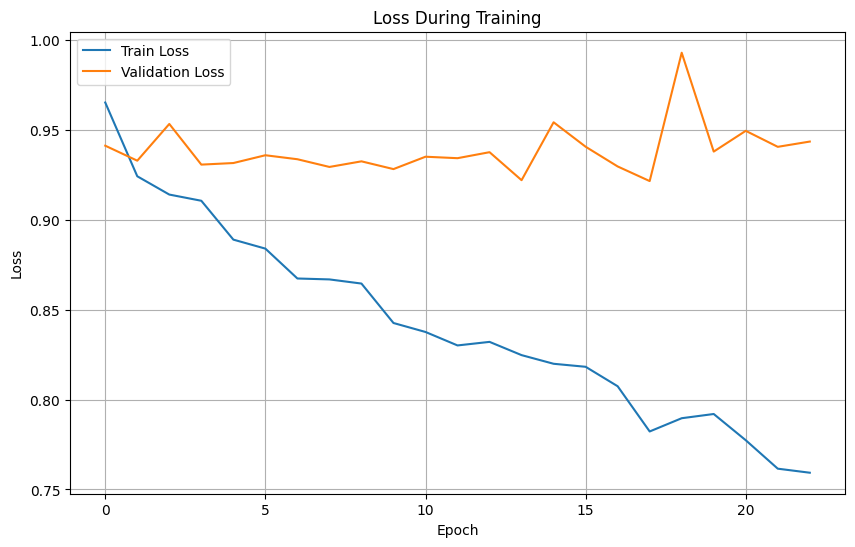


Evaluating on Validation set...


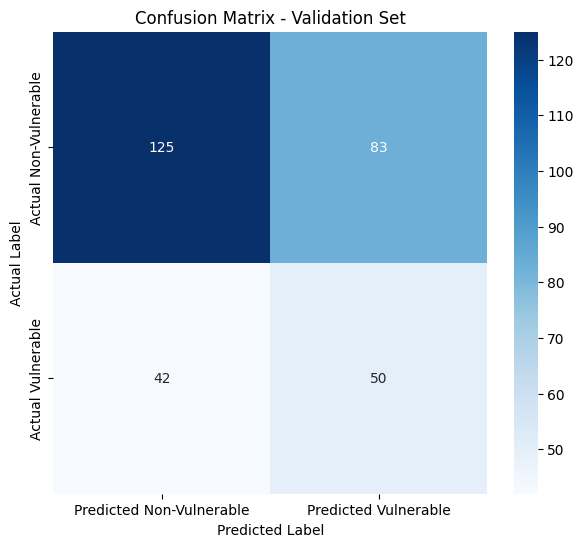

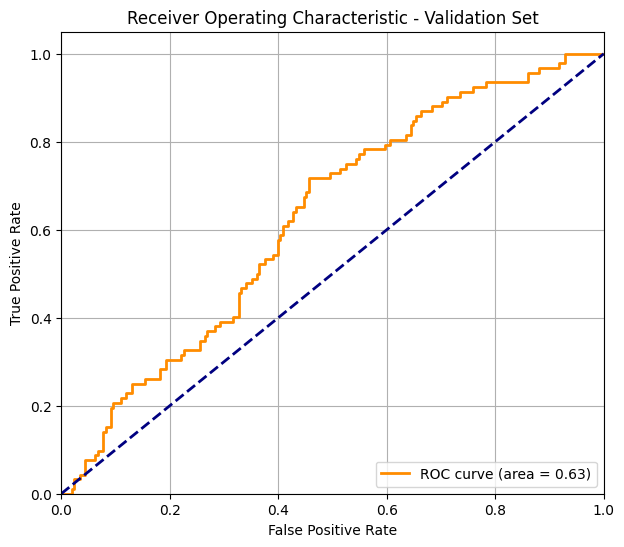


Evaluating on Test set...


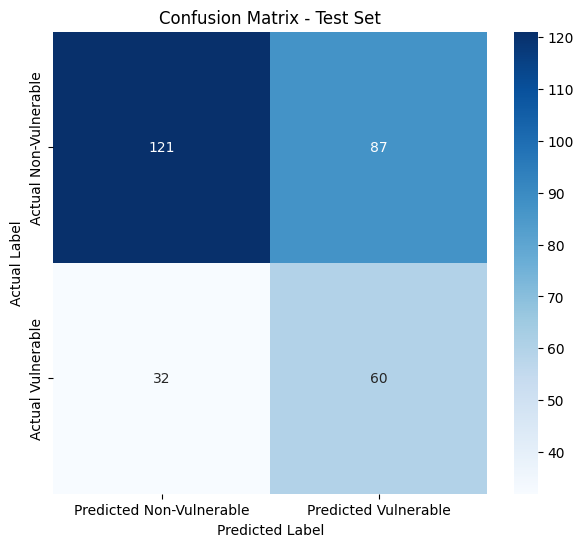

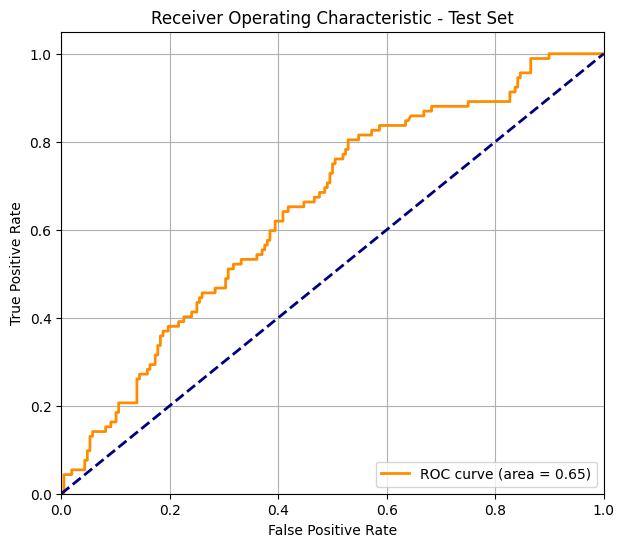


--- Validation Set Evaluation Results ---
Precision: 0.3759
Recall: 0.5435
F1-Score: 0.4444
Accuracy: 0.5833
ROC-AUC: 0.6264

--- Test Set Evaluation Results ---
Precision: 0.4082
Recall: 0.6522
F1-Score: 0.5021
Accuracy: 0.6033
ROC-AUC: 0.6486


In [63]:
num_epochs = 50
train_losses, val_losses = train_enhanced_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print("\nEvaluating on Validation set...")
precision_v_e, recall_v_e, f1_v_e, accuracy_v_e, roc_auc_v_e = evaluate_enhanced_model(model, val_loader, set_name="Validation")

print("\nEvaluating on Test set...")
precision_t_e, recall_t_e, f1_t_e, accuracy_t_e, roc_auc_t_e = evaluate_enhanced_model(model, test_loader, set_name="Test")

print(f"\n--- Validation Set Evaluation Results ---")
print(f"Precision: {precision_v_e:.4f}")
print(f"Recall: {recall_v_e:.4f}")
print(f"F1-Score: {f1_v_e:.4f}")
print(f"Accuracy: {accuracy_v_e:.4f}")
print(f"ROC-AUC: {roc_auc_v_e:.4f}")

print(f"\n--- Test Set Evaluation Results ---")
print(f"Precision: {precision_t_e:.4f}")
print(f"Recall: {recall_t_e:.4f}")
print(f"F1-Score: {f1_t_e:.4f}")
print(f"Accuracy: {accuracy_t_e:.4f}")
print(f"ROC-AUC: {roc_auc_t_e:.4f}")

In [64]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [65]:
def evaluate_thresholds(model, data_loader, set_name="Test", thresholds=np.arange(0, 1.01, 0.01)):
    model.eval()
    all_probabilities = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            all_probabilities.extend(probs)
            all_labels.extend(labels.numpy().flatten())

    all_probabilities = np.array(all_probabilities)
    all_labels = np.array(all_labels)

    precisions, recalls, f1s, accuracies = [], [], [], []

    for thresh in thresholds:
        preds = (all_probabilities > thresh).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, preds, average='binary', zero_division=0)
        accuracy = accuracy_score(all_labels, preds)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        accuracies.append(accuracy)

    try:
        roc_auc = roc_auc_score(all_labels, all_probabilities)
    except ValueError:
        roc_auc = 0.0

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=thresholds, y=precisions, mode='lines', name='Precision', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=thresholds, y=recalls, mode='lines', name='Recall', line=dict(color='green')))
    fig.add_trace(go.Scatter(x=thresholds, y=f1s, mode='lines', name='F1 Score', line=dict(color='red')))
    fig.add_trace(go.Scatter(x=thresholds, y=accuracies, mode='lines', name='Accuracy', line=dict(color='purple')))

    fig.update_layout(
        title=f'Precision, Recall, F1 Score, Accuracy vs Threshold - {set_name} Set<br>ROC-AUC: {roc_auc:.3f}',
        xaxis_title='Decision Threshold',
        yaxis_title='Score',
        xaxis=dict(range=[0, 1]),
        yaxis=dict(range=[0, 1]),
        legend=dict(x=0.7, y=0.1),
        template='plotly_white',
        width=900,
        height=600
    )

    fig.show()

    best_idx = np.argmax(f1s)
    best_thresh = thresholds[best_idx]
    print(f"Best threshold by F1: {best_thresh:.2f} with F1: {f1s[best_idx]:.4f}")

    return best_thresh, precisions, recalls, f1s, accuracies, roc_auc

In [66]:
best_thresh, precisions, recalls, f1s, accuracies, roc_auc = evaluate_thresholds(model, test_loader, set_name="Test")

Best threshold by F1: 0.43 with F1: 0.5324



Evaluating on Validation set...


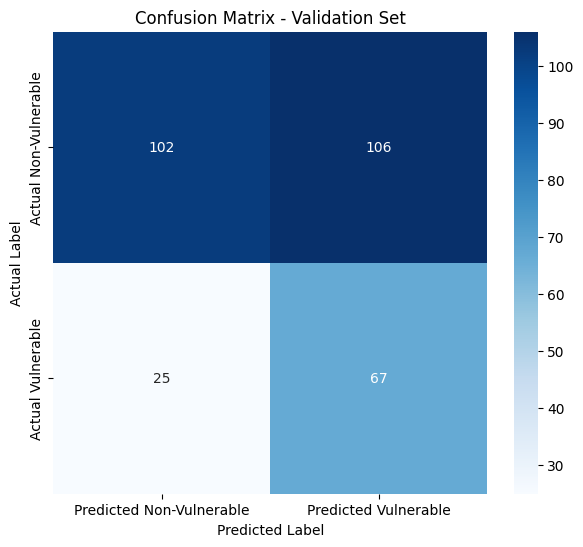

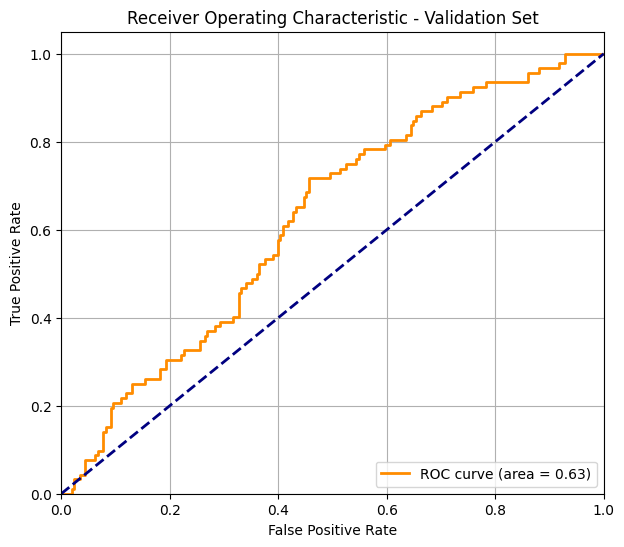


Evaluating on Test set...


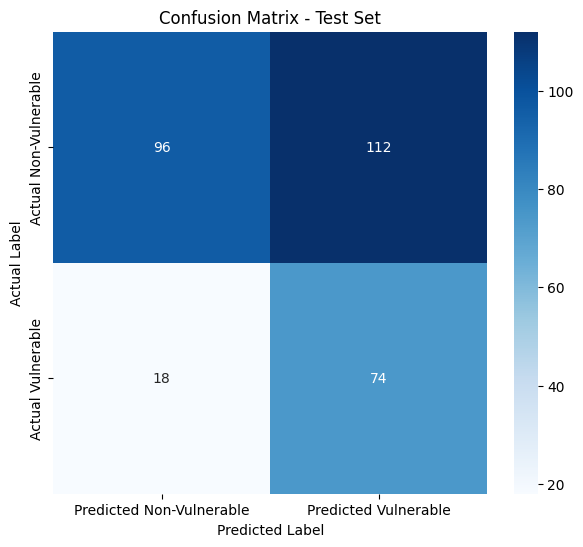

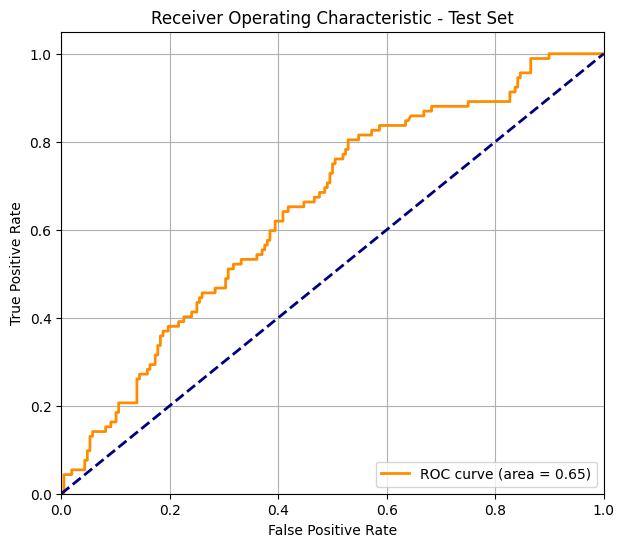


--- Validation Set Evaluation Results ---
Precision: 0.3873
Recall: 0.7283
F1-Score: 0.5057
Accuracy: 0.5633
ROC-AUC: 0.6264

--- Test Set Evaluation Results ---
Precision: 0.3978
Recall: 0.8043
F1-Score: 0.5324
Accuracy: 0.5667
ROC-AUC: 0.6486


In [67]:
best_threshold = best_thresh
print("\nEvaluating on Validation set...")
precision_v_e, recall_v_e, f1_v_e, accuracy_v_e, roc_auc_v_e = evaluate_enhanced_model(model, val_loader, set_name="Validation", threshold=best_threshold)

print("\nEvaluating on Test set...")
precision_t_e, recall_t_e, f1_t_e, accuracy_t_e, roc_auc_t_e = evaluate_enhanced_model(model, test_loader, set_name="Test", threshold=best_threshold)

print(f"\n--- Validation Set Evaluation Results ---")
print(f"Precision: {precision_v_e:.4f}")
print(f"Recall: {recall_v_e:.4f}")
print(f"F1-Score: {f1_v_e:.4f}")
print(f"Accuracy: {accuracy_v_e:.4f}")
print(f"ROC-AUC: {roc_auc_v_e:.4f}")

print(f"\n--- Test Set Evaluation Results ---")
print(f"Precision: {precision_t_e:.4f}")
print(f"Recall: {recall_t_e:.4f}")
print(f"F1-Score: {f1_t_e:.4f}")
print(f"Accuracy: {accuracy_t_e:.4f}")
print(f"ROC-AUC: {roc_auc_t_e:.4f}")